In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

In [2]:
pathToSave = 'RAPzs/'
pathToTestingMetricF1 = pathToSave+'/testing_dict_instance_f1.json'
pathToTestingDataGTPredicted = pathToSave+'/testing_dict_gt_predicted.json'

pathOfDataset = '/mnt/rhome/paa/pedestrian/Rethinking_of_PAR/data/RAP2/RAP_dataset/'
typeImage = '.png'

pathToTrainingMetricF1 = pathToSave+'/training_dict_instance_f1.json'
pathToTrainingDataGTPredicted = pathToSave+'/training_dict_gt_predicted.json'

listAttributesRAPv2 = ['hs-BaldHead', 'hs-LongHair', 'hs-BlackHair', 'hs-Hat', 'hs-Glasses','ub-Shirt','ub-Sweater','ub-Vest','ub-TShirt','ub-Cotton','ub-Jacket','ub-SuitUp','ub-Tight','ub-ShortSleeve','ub-Others','lb-LongTrousers','lb-Skirt','lb-ShortSkirt','lb-Dress','lb-Jeans','lb-TightTrousers','shoes-Leather', 'shoes-Sports', 'shoes-Boots', 'shoes-Cloth', 'shoes-Casual', 'shoes-Other','attachment-Backpack','attachment-ShoulderBag','attachment-HandBag','attachment-Box','attachment-PlasticBag','attachment-PaperBag','attachment-HandTrunk','attachment-Other','AgeLess16', 'Age17-30', 'Age31-45', 'Age46-60','Female','BodyFat','BodyNormal','BodyThin','Customer','Employee','action-Calling','action-Talking','action-Gathering','action-Holding','action-Pushing','action-Pulling','action-CarryingByArm','action-CarryingByHand','action-Other']
listAttributesRAPzs = listAttributesRAPv2

listAttributesRAPzs.remove('Age46-60')

columnsDF = ['value F1', 'nameImg']
columnsDF.extend(listAttributesRAPzs)

fileTestingGTPredicted = open(pathToTestingDataGTPredicted)
jsonTestingGTPredicted = json.load(fileTestingGTPredicted)

fileTrainingGTPredicted = open(pathToTrainingDataGTPredicted)
jsonTrainingGTPredicted = json.load(fileTrainingGTPredicted)

fileTestingInstance = open(pathToTestingMetricF1)
jsonTestingInstance = json.load(fileTestingInstance)

fileTrainingInstance = open(pathToTrainingMetricF1)
jsonTrainingInstance = json.load(fileTrainingInstance)

In [3]:
def calculateF1MetricByInstance(gt_label, pred_label):
    eps = 1e-20
    # instance metrics
    gt_pos = np.sum((gt_label == 1), axis=1).astype(float)
    true_pos = np.sum((pred_label == 1), axis=1).astype(float)
    # true positive
    intersect_pos = np.sum((gt_label == 1) * (pred_label == 1), axis=1).astype(float)

    instance_prec_label = intersect_pos / (true_pos + eps)
    instance_recall_label = intersect_pos / (gt_pos + eps)
    instance_f1_label = 2 * instance_prec_label * instance_recall_label / (instance_prec_label + instance_recall_label + eps)
    
    return instance_f1_label


In [4]:
def testingAnalysisIdentities(attributeToAnalyze, jsonTestingGTPredicted, listAttributes, jsonTestingInstance):
    indexOFAttribute = listAttributesRAPzs.index(attributeToAnalyze)
    columnsDFGT = [item + ' gt' for item in listAttributes]
    columnsDFPred= [item + ' pred' for item in listAttributes]
    columnsDF = columnsDFGT + columnsDFPred
    

    valuesGTTesting = jsonTestingGTPredicted['testing gt']
    allImages = jsonTestingInstance['img name testing']
    nameImages = [image for images in allImages for image in images]
    

    valuesPredictedTestingOld = jsonTestingGTPredicted['testing predicted']

    dictTestingGTPredicted = dict.fromkeys(columnsDF)
    dictTestingGTPredicted['name image'] = nameImages
    for column in columnsDFGT:
        dictTestingGTPredicted[column] = [int(vector[columnsDFGT.index(column)]) for vector in valuesGTTesting]

    for column in columnsDFPred:
        dictTestingGTPredicted[column] = [int(vector[columnsDFPred.index(column)]) for vector in valuesPredictedTestingOld]

    dfTestingRAPzsIdentitites = pd.DataFrame.from_dict(dictTestingGTPredicted)


    datasetWithAttribute = dfTestingRAPzsIdentitites[(dfTestingRAPzsIdentitites[attributeToAnalyze+' gt']==1)]
    gtWithAttribute = datasetWithAttribute[columnsDFGT].to_numpy()
    gtWithAttribute = np.delete(gtWithAttribute, indexOFAttribute, 1)
    predWithAttribute = datasetWithAttribute[columnsDFPred].to_numpy()
    predWithAttribute = np.delete(predWithAttribute, indexOFAttribute, 1)


    datasetWithOutAttribute = dfTestingRAPzsIdentitites[(dfTestingRAPzsIdentitites[attributeToAnalyze+' gt']==0)]
    gtWithOutAttribute = datasetWithOutAttribute[columnsDFGT].to_numpy()
    gtWithOutAttribute = np.delete(gtWithOutAttribute, indexOFAttribute, 1)
    predWithOutAttribute = datasetWithOutAttribute[columnsDFPred].to_numpy()
    predWithOutAttribute = np.delete(predWithOutAttribute, indexOFAttribute, 1)

    instanceF1withAttribute=calculateF1MetricByInstance(gtWithAttribute, predWithAttribute)
    instanceF1withOutAttribute=calculateF1MetricByInstance(gtWithOutAttribute, predWithOutAttribute)

    dfTestingRAPzsIdentitesPerformanceNameImage = pd.DataFrame()
    dfTestingRAPzsIdentitesPerformanceNameImage['name image'] = datasetWithAttribute['name image']
    dfTestingRAPzsIdentitesPerformanceNameImage['performance with attribute'] = instanceF1withAttribute

    numWithAttribute = len(instanceF1withAttribute)
    numWihtOutAttribute = len(instanceF1withOutAttribute)
    listNum = [numWithAttribute, numWihtOutAttribute]
    listNumName = ['With Attribute', 'Without Attribute']

    
    #plt.pie(listNum, labels=listNumName, autopct='%1.1f%%')
    #plt.title("Representation of the "+attributeToAnalyze+" on the testing dataset")
    #plt.show()
    
    meanInstanceF1withAttribute = np.mean(instanceF1withAttribute)
    varInstanceF1withAttribute = np.var(instanceF1withAttribute)
    meanInstanceF1withOutAttribute = np.mean(instanceF1withOutAttribute)
    varInstanceF1withOutAttribute = np.var(instanceF1withOutAttribute)
    
    return listNum, listNumName, instanceF1withAttribute, instanceF1withOutAttribute, meanInstanceF1withAttribute, varInstanceF1withAttribute, meanInstanceF1withOutAttribute, varInstanceF1withOutAttribute, dfTestingRAPzsIdentitesPerformanceNameImage

In [5]:
def trainingAnalysisIdentities(attributeToAnalyze, jsonTrainingGTPredicted, listAttributes, jsonTrainingInstance):
    indexOFAttribute = listAttributesRAPzs.index(attributeToAnalyze)
    columnsDFGT = [item + ' gt' for item in listAttributes]
    columnsDFPred= [item + ' pred' for item in listAttributes]
    columnsDF = columnsDFGT + columnsDFPred

    valuesGTTraining = jsonTrainingGTPredicted['training gt']
    valuesPredictedTrainingOld = jsonTrainingGTPredicted['training predicted']
    allImages = jsonTrainingInstance['img name training']
    nameImages = [image for images in allImages for image in images]
    
    dictTrainingGTPredicted = dict.fromkeys(columnsDF)
    dictTrainingGTPredicted['name image'] = nameImages
    for column in columnsDFGT:
        dictTrainingGTPredicted[column] = [int(vector[columnsDFGT.index(column)]) for vector in valuesGTTraining]

    for column in columnsDFPred:
        dictTrainingGTPredicted[column] = [int(vector[columnsDFPred.index(column)]) for vector in valuesPredictedTrainingOld]

    dfTrainingRAPzsIdentitites = pd.DataFrame.from_dict(dictTrainingGTPredicted)

    datasetWithAttribute = dfTrainingRAPzsIdentitites[(dfTrainingRAPzsIdentitites[attributeToAnalyze+' gt']==1)]
    gtWithAttribute = datasetWithAttribute[columnsDFGT].to_numpy()
    gtWithAttribute = np.delete(gtWithAttribute, indexOFAttribute, 1)
    predWithAttribute = datasetWithAttribute[columnsDFPred].to_numpy()
    predWithAttribute = np.delete(predWithAttribute, indexOFAttribute, 1)


    datasetWithOutAttribute = dfTrainingRAPzsIdentitites[(dfTrainingRAPzsIdentitites[attributeToAnalyze+' gt']==0)]
    gtWithOutAttribute = datasetWithOutAttribute[columnsDFGT].to_numpy()
    gtWithOutAttribute = np.delete(gtWithOutAttribute, indexOFAttribute, 1)
    predWithOutAttribute = datasetWithOutAttribute[columnsDFPred].to_numpy()
    predWithOutAttribute = np.delete(predWithOutAttribute, indexOFAttribute, 1)

    instanceF1withAttribute=calculateF1MetricByInstance(gtWithAttribute, predWithAttribute)
    instanceF1withOutAttribute=calculateF1MetricByInstance(gtWithOutAttribute, predWithOutAttribute)
    
    dfTrainingRAPzsIdentitesPerformanceNameImage = pd.DataFrame()
    dfTrainingRAPzsIdentitesPerformanceNameImage['name image'] = datasetWithAttribute['name image']
    dfTrainingRAPzsIdentitesPerformanceNameImage['performance with attribute'] = instanceF1withAttribute

    numWithAttribute = len(instanceF1withAttribute)
    numWihtOutAttribute = len(instanceF1withOutAttribute)
    listNum = [numWithAttribute, numWihtOutAttribute]
    listNumName = ['With Attribute', 'Without Attribute']

    #plt.pie(listNum, labels=listNumName, autopct='%1.1f%%')
    #plt.title("Representation of the "+attributeToAnalyze+" on the training dataset")
    #plt.show()
    
    meanInstanceF1withAttribute = np.mean(instanceF1withAttribute)
    varInstanceF1withAttribute = np.var(instanceF1withAttribute)
    meanInstanceF1withOutAttribute = np.mean(instanceF1withOutAttribute)
    varInstanceF1withOutAttribute = np.var(instanceF1withOutAttribute)
    
    return listNum, listNumName, instanceF1withAttribute, instanceF1withOutAttribute, meanInstanceF1withAttribute, varInstanceF1withAttribute, meanInstanceF1withOutAttribute, varInstanceF1withOutAttribute, dfTrainingRAPzsIdentitesPerformanceNameImage

In [6]:
def plottingImageAnalysis(attributeToAnalyze, listNumTraining,listNumNameTraining, listNumTesting, instanceF1withAttributeTraining,instanceF1withOutAttributeTraining, instanceF1withAttributeTesting, instanceF1withOutAttributeTesting):
    fig, ax = plt.subplots(1,2)
    labels=listNumNameTraining
    ax[0].pie(listNumTraining,  autopct='%1.1f%%')
    ax[0].set_title('Training')
    ax[1].pie(listNumTesting,  autopct='%1.1f%%')
    ax[1].set_title('Testing')
    fig.suptitle('Representation of the '+attributeToAnalyze+' on the training dataset')
    #plt.title("Representation of the "+attributeToAnalyze+" on the training dataset")
    fig.legend(labels, loc='upper right',bbox_to_anchor=[1.3, 1.05], bbox_transform=fig.transFigure)
    plt.savefig(pathToSave+attributeToAnalyze+'/representationTrainingTesting.pdf')

    maxValue = 0
    if max(instanceF1withAttributeTraining) > maxValue:
        maxValue = max(instanceF1withAttributeTraining)
    if max(instanceF1withOutAttributeTraining) > maxValue:
        maxValue = max(instanceF1withOutAttributeTraining)
    if max(instanceF1withAttributeTesting) > maxValue:
        maxValue = max(instanceF1withAttributeTesting)
    if max(instanceF1withOutAttributeTesting) > maxValue:
        maxValue = max(instanceF1withOutAttributeTesting)
    
    instanceF1withAttributeNormalizedTraining = instanceF1withAttributeTraining/np.max(maxValue)
    instanceF1withOutAttributeNormalizedTraining = instanceF1withOutAttributeTraining/np.max(maxValue)
    instanceF1withAttributeNormalizedTesting = instanceF1withAttributeTesting/np.max(maxValue)
    instanceF1withOutAttributeNormalizedTesting = instanceF1withOutAttributeTesting/np.max(maxValue)

    fig, ax = plt.subplots(1,2)
    labels=[]
    #ax[0].subplot(1, 2, 1)
    label='Attributes in images with '+attributeToAnalyze
    labels.append(label)
    ax[0].hist(instanceF1withAttributeNormalizedTraining,alpha=0.75,density=True, label=label)
    label='Attributes in images without '+attributeToAnalyze
    labels.append(label)
    ax[0].hist(instanceF1withOutAttributeNormalizedTraining,alpha=0.75,density=True, label=label)
    ax[0].set_title('Training')
    #ax[0].set_xlabel('Performance (F1) in training')
    #ax[0].set_ylabel('Count identities with that performance')
    #tittle='Histogram RAPzs performance in training'
    #plt.legend(title=tittle, fontsize='small', fancybox=True)
    #plt.show()


    #plt.subplot(1, 2, 2)
    label='Attributes in images with '+attributeToAnalyze
    #labels.append(label)
    ax[1].hist(instanceF1withAttributeNormalizedTesting,alpha=0.75,density=True, label=label)
    label='Attributes in images without '+attributeToAnalyze
    #labels.append(label)
    ax[1].hist(instanceF1withOutAttributeNormalizedTesting,alpha=0.75,density=True, label=label)
    ax[1].set_title('Testing')
    #ax[1].set_xlabel('Performance (F1) in testing')
    #ax[1].set_ylabel('Count identities with that performance')
    tittle='Histogram RAPzs performance'

    plt.setp(ax[:], xlabel='Performance (F1)')
    plt.setp(ax[0], ylabel='Count identities with that performance')

    fig.suptitle(tittle)
    fig.legend(labels, loc='upper right', bbox_to_anchor=[1.5, 1.05], bbox_transform=fig.transFigure)

    #plt.legend(title=tittle, fontsize='small', fancybox=True)

    plt.savefig(pathToSave+attributeToAnalyze+'/histogramsTrainingTesting.pdf')

    return instanceF1withAttributeNormalizedTraining, instanceF1withOutAttributeNormalizedTraining, instanceF1withAttributeNormalizedTesting, instanceF1withOutAttributeNormalizedTesting

In [7]:
def getAnalysisIdentitieByAttribute(attributeToAnalyze, jsonTestingGTPredicted,jsonTrainingGTPredicted, listAttributes, jsonTrainingInstance, jsonTestingInstance):
    listNumTesting, listNumNameTesting, instanceF1withAttributeTesting, instanceF1withOutAttributeTesting, meanInstanceF1withAttributeTesting, varInstanceF1withAttributeTesting,meanInstanceF1withOutAttributeTesting, varInstanceF1withOutAttributeTesting, dfTestingRAPzsIdentitesPerformanceNameImage = testingAnalysisIdentities(attributeToAnalyze, jsonTestingGTPredicted, listAttributes, jsonTestingInstance)
    listNumTraining, listNumNameTraining,instanceF1withAttributeTraining, instanceF1withOutAttributeTraining, meanInstanceF1withAttributeTraining, varInstanceF1withAttributeTraining,meanInstanceF1withOutAttributeTraining, varInstanceF1withOutAttributeTraining, dfTrainingRAPzsIdentitesPerformanceNameImage = trainingAnalysisIdentities(attributeToAnalyze, jsonTrainingGTPredicted, listAttributes, jsonTrainingInstance)

    print("Mean F1 performance training with "+attributeToAnalyze+" -> "+str(meanInstanceF1withAttributeTraining))
    print("Variance F1 performance training with "+attributeToAnalyze+" -> "+str(varInstanceF1withAttributeTraining))

    print("Mean F1 performance without "+attributeToAnalyze+" -> "+str(meanInstanceF1withOutAttributeTraining))
    print("Variance F1 performance training with "+attributeToAnalyze+" -> "+str(varInstanceF1withOutAttributeTraining))

    print("Mean F1 performance testing with "+attributeToAnalyze+" -> "+str(meanInstanceF1withAttributeTesting))
    print("Variance F1 performance testing with "+attributeToAnalyze+" -> "+str(varInstanceF1withAttributeTesting))

    print("Mean F1 performance testing without "+attributeToAnalyze+" -> "+str(meanInstanceF1withOutAttributeTesting))
    print("Variance F1 performance testing with "+attributeToAnalyze+" -> "+str(varInstanceF1withOutAttributeTesting))

    instanceF1withAttributeNormalizedTraining, instanceF1withOutAttributeNormalizedTraining, instanceF1withAttributeNormalizedTesting, instanceF1withOutAttributeNormalizedTesting = plottingImageAnalysis(attributeToAnalyze, listNumTraining,listNumNameTraining, listNumTesting, instanceF1withAttributeTraining,instanceF1withOutAttributeTraining, instanceF1withAttributeTesting, instanceF1withOutAttributeTesting)

    bin_edges = np.histogram_bin_edges(np.concatenate([instanceF1withAttributeNormalizedTraining, instanceF1withOutAttributeNormalizedTraining]))
    histWithAttributeTraining, _ = np.histogram(instanceF1withAttributeNormalizedTraining, bins=bin_edges)
    histWithOutAttributeTraining, _ = np.histogram(instanceF1withOutAttributeNormalizedTraining, bins=bin_edges)

    interectTraining = np.minimum(histWithAttributeTraining, histWithOutAttributeTraining)
    areaTraining = interectTraining.sum()

    bin_edges = np.histogram_bin_edges(np.concatenate([instanceF1withAttributeNormalizedTesting, instanceF1withOutAttributeNormalizedTesting]))
    histWithAttributeTesting, _ = np.histogram(instanceF1withAttributeNormalizedTesting, bins=bin_edges)
    histWithOutAttributeTesting, _ = np.histogram(instanceF1withOutAttributeNormalizedTesting, bins=bin_edges)

    interectTesting = np.minimum(histWithAttributeTesting, histWithOutAttributeTesting)
    areaTesting = interectTesting.sum()

    print("Area intersection training "+str(areaTraining))
    print("Area intersection testing "+str(areaTesting))


    return areaTraining, areaTesting, meanInstanceF1withAttributeTraining, varInstanceF1withAttributeTraining, \
        meanInstanceF1withOutAttributeTraining, varInstanceF1withOutAttributeTraining, meanInstanceF1withAttributeTesting, \
        varInstanceF1withAttributeTesting, meanInstanceF1withOutAttributeTesting, varInstanceF1withOutAttributeTesting, \
        dfTestingRAPzsIdentitesPerformanceNameImage, dfTrainingRAPzsIdentitesPerformanceNameImage, listNumTraining, listNumTesting


In [8]:
from PIL import Image

Mean F1 performance training with hs-BaldHead -> 0.9056983791003488
Variance F1 performance training with hs-BaldHead -> 0.009803070792450215
Mean F1 performance without hs-BaldHead -> 0.9313056135551596
Variance F1 performance training with hs-BaldHead -> 0.005955155732741846
Mean F1 performance testing with hs-BaldHead -> 0.6757717414451161
Variance F1 performance testing with hs-BaldHead -> 0.02592170311417158
Mean F1 performance testing without hs-BaldHead -> 0.7685831811465818
Variance F1 performance testing with hs-BaldHead -> 0.017791969438911804
Area intersection training 116
Area intersection testing 6
Mean F1 performance training with hs-LongHair -> 0.9348110189779273
Variance F1 performance training with hs-LongHair -> 0.005473798691306717
Mean F1 performance without hs-LongHair -> 0.9300161913006993
Variance F1 performance training with hs-LongHair -> 0.0062334097440034306
Mean F1 performance testing with hs-LongHair -> 0.7501850475467499
Variance F1 performance testing wit

/home/paa/.conda/envs/rethinking/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Area intersection training 5845
Area intersection testing 1295
Mean F1 performance training with ub-SuitUp -> 0.9286092336255185
Variance F1 performance training with ub-SuitUp -> 0.00748104663543258
Mean F1 performance without ub-SuitUp -> 0.9312608050857173
Variance F1 performance training with ub-SuitUp -> 0.0059395516133882945
Mean F1 performance testing with ub-SuitUp -> 0.7918616230283646
Variance F1 performance testing with ub-SuitUp -> 0.017879710732882904
Mean F1 performance testing without ub-SuitUp -> 0.7682874519142309
Variance F1 performance testing with ub-SuitUp -> 0.017755986849421146
Area intersection training 459
Area intersection testing 112
Mean F1 performance training with ub-Tight -> 0.9157008734524931
Variance F1 performance training with ub-Tight -> 0.007774861499360224
Mean F1 performance without ub-Tight -> 0.9318215000028109
Variance F1 performance training with ub-Tight -> 0.005913018222222266
Mean F1 performance testing with ub-Tight -> 0.73627498728881
Var

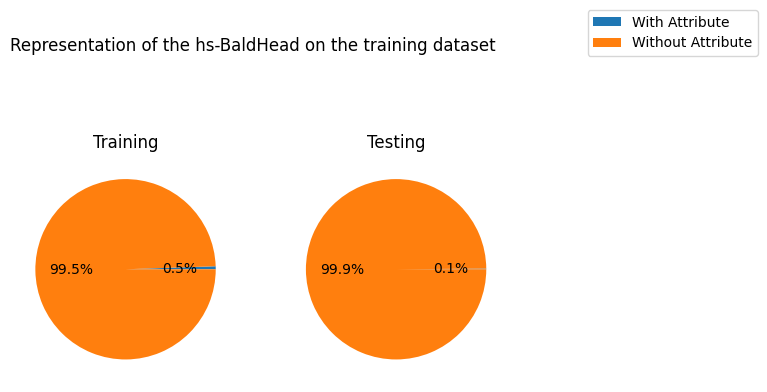

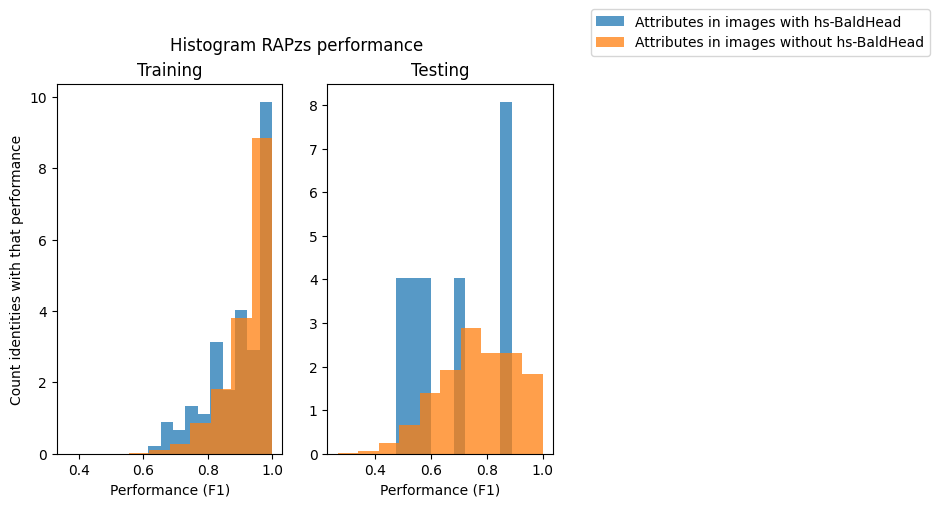

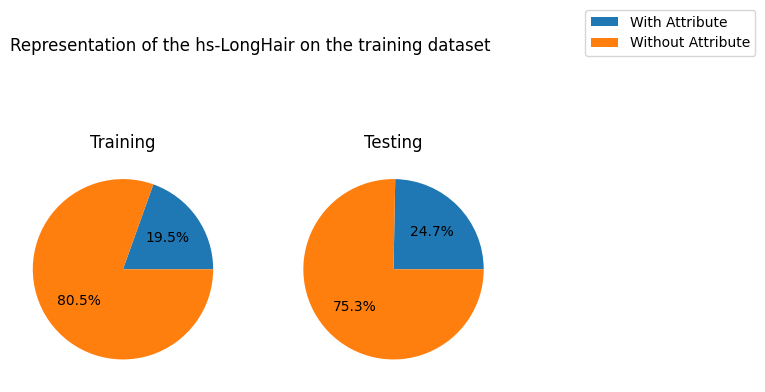

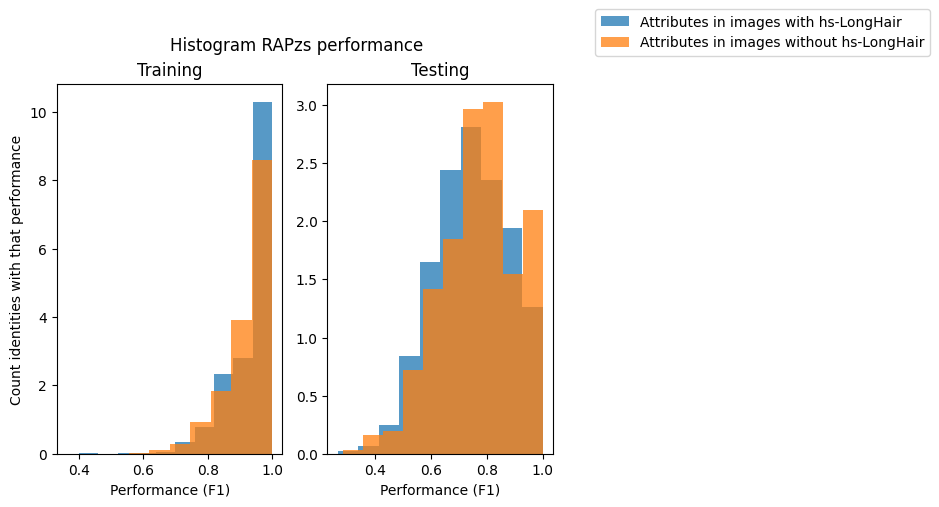

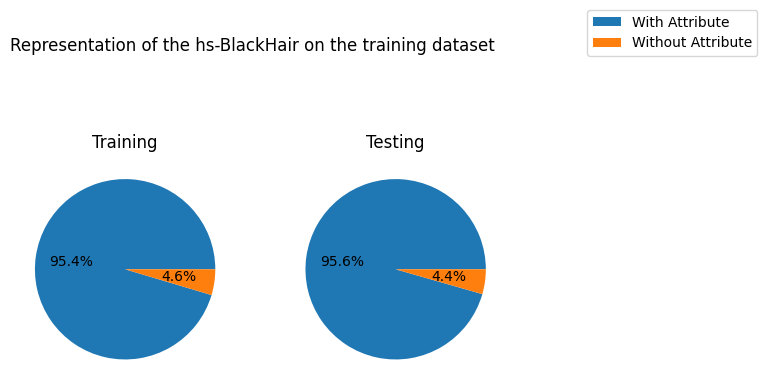

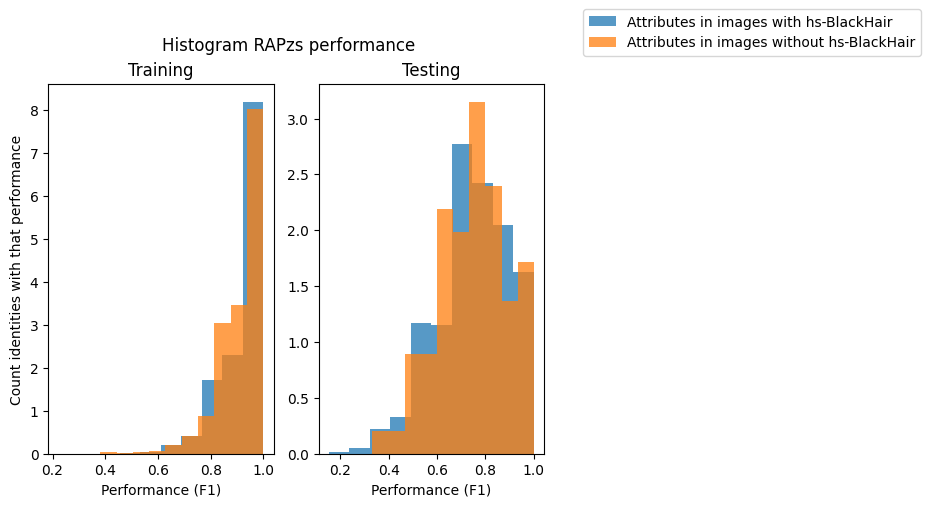

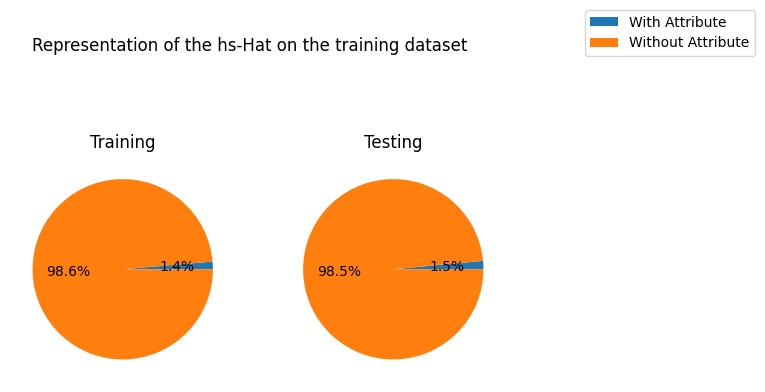

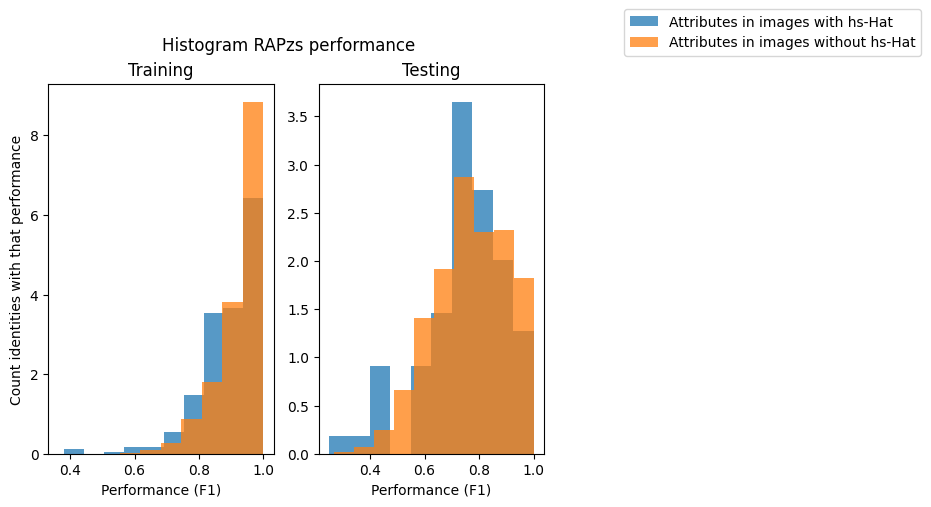

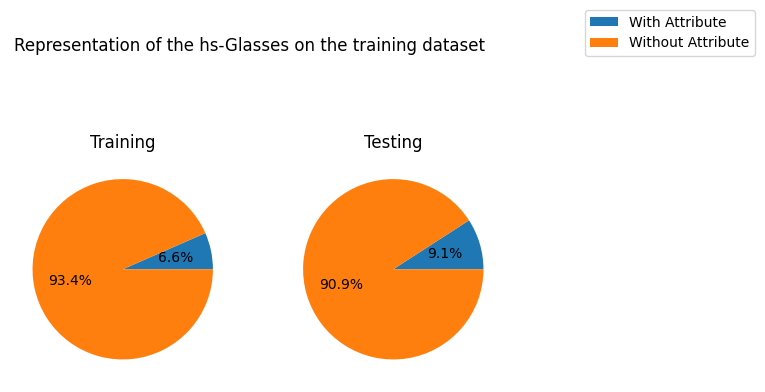

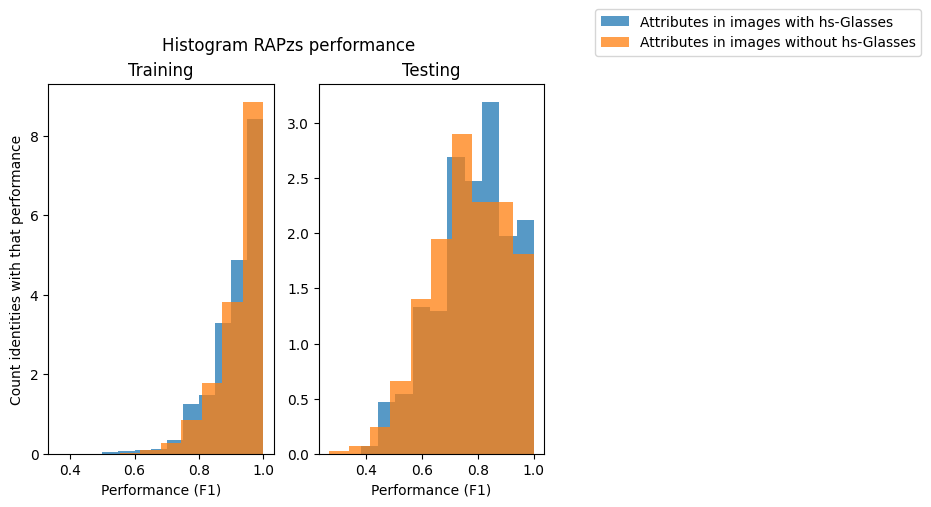

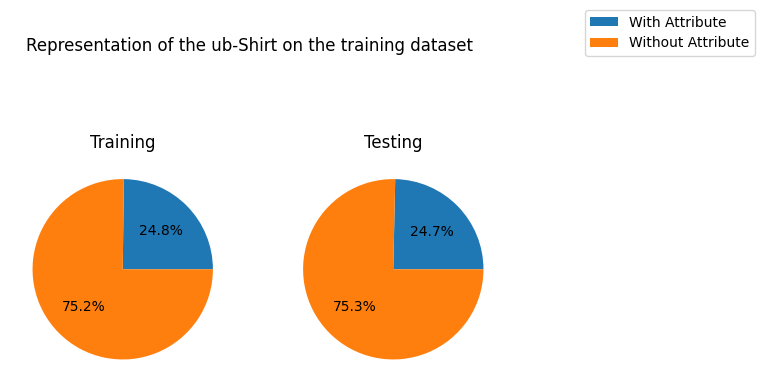

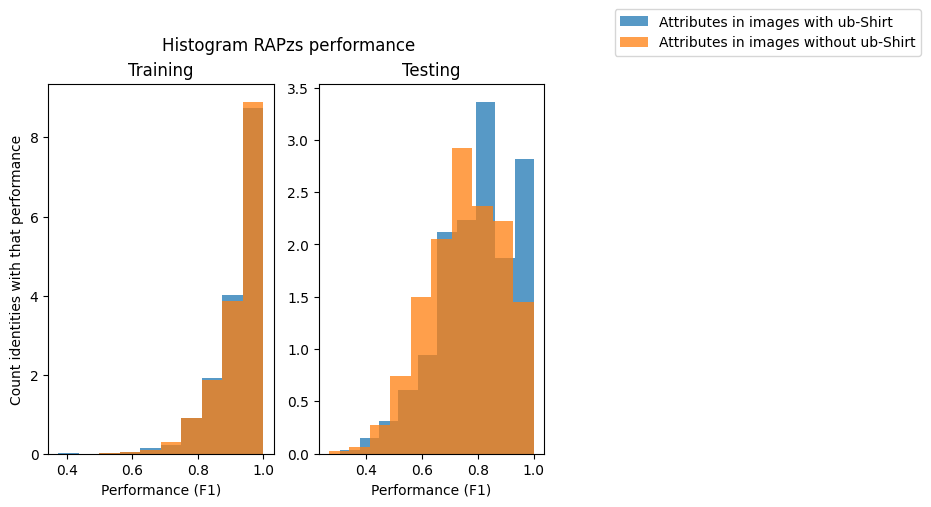

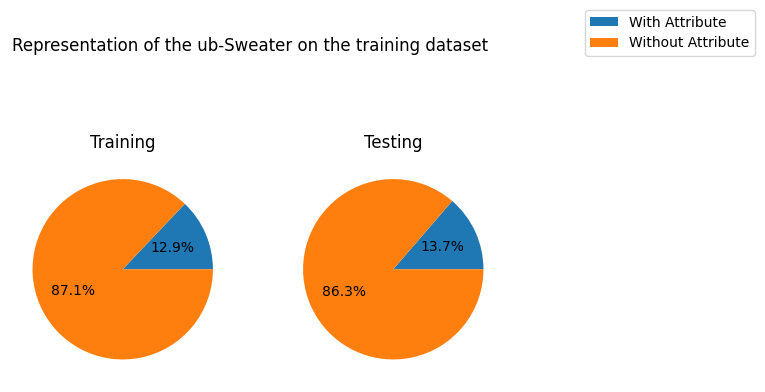

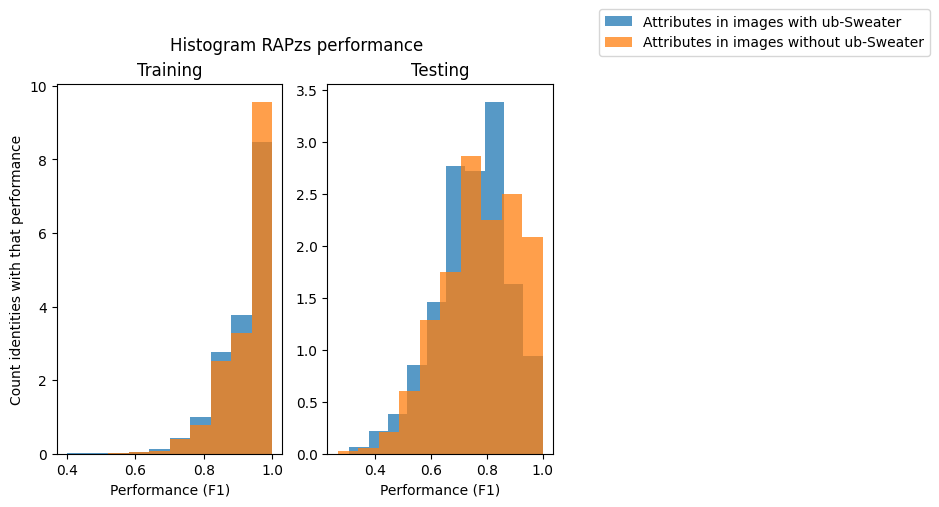

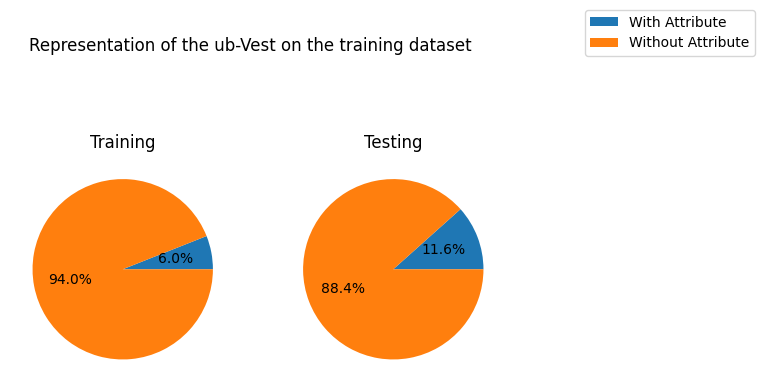

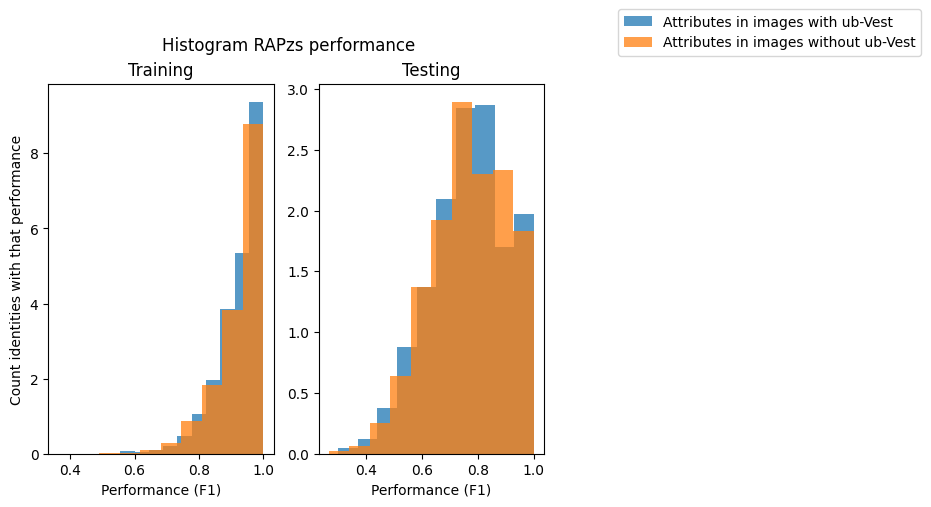

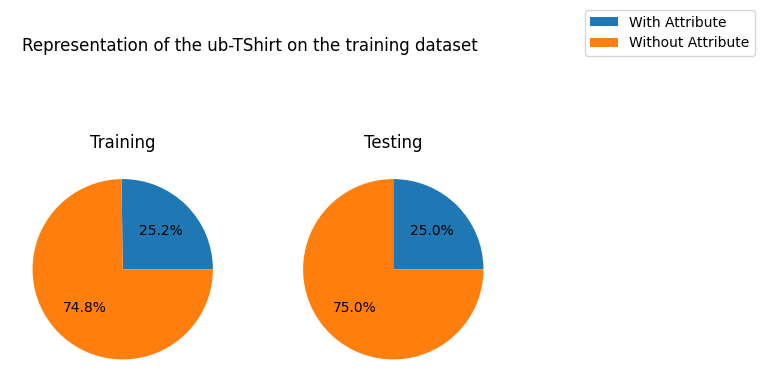

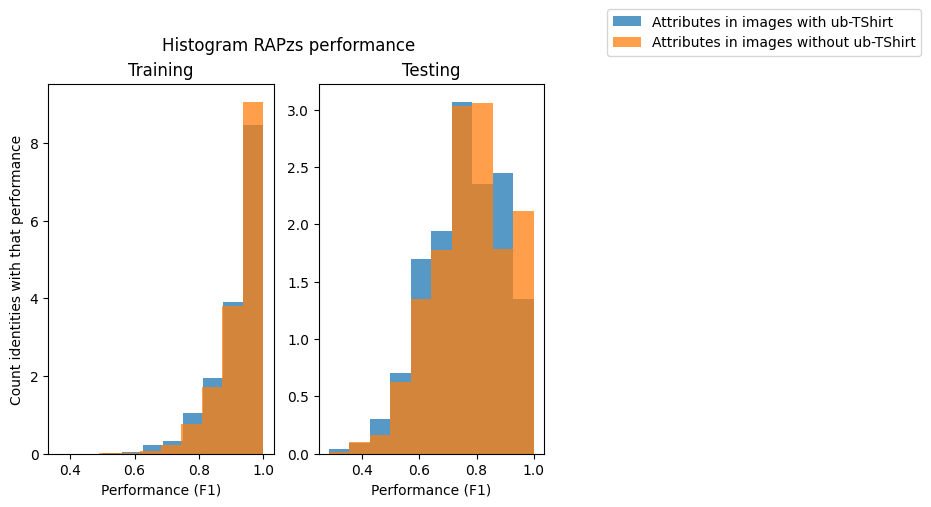

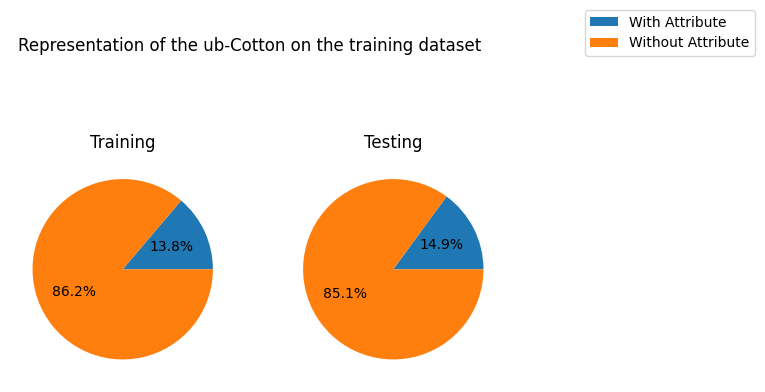

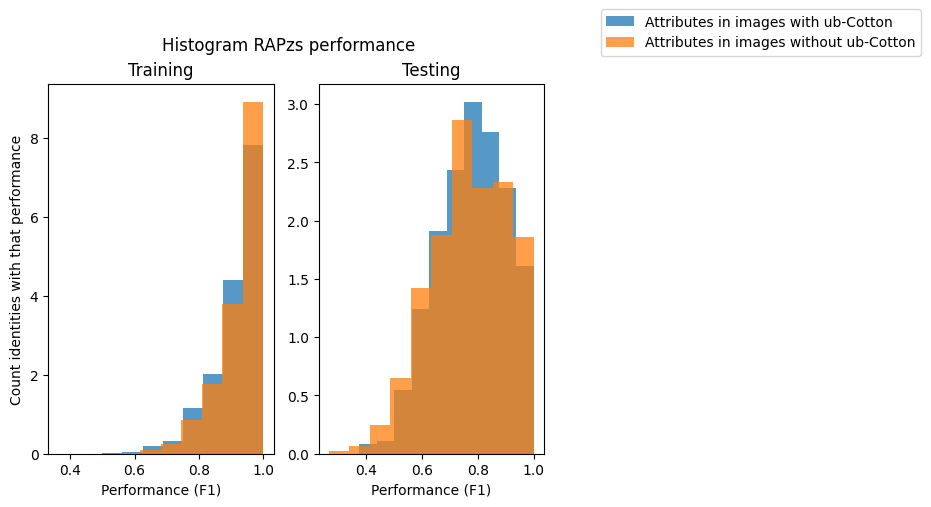

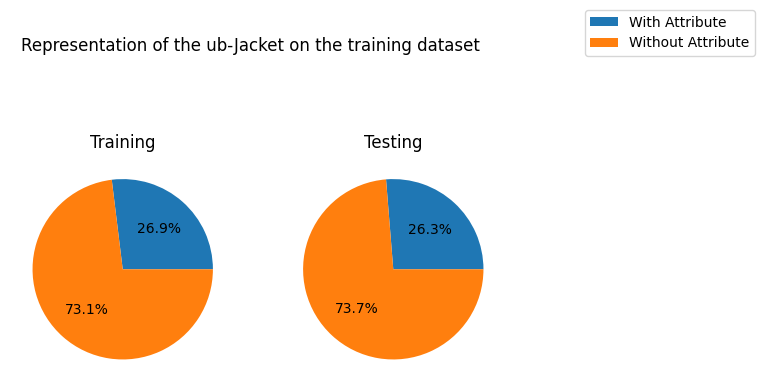

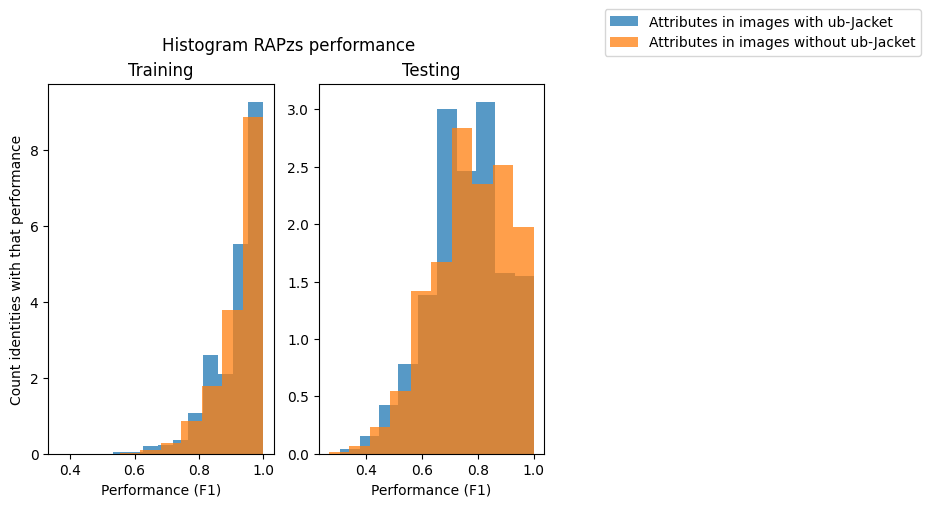

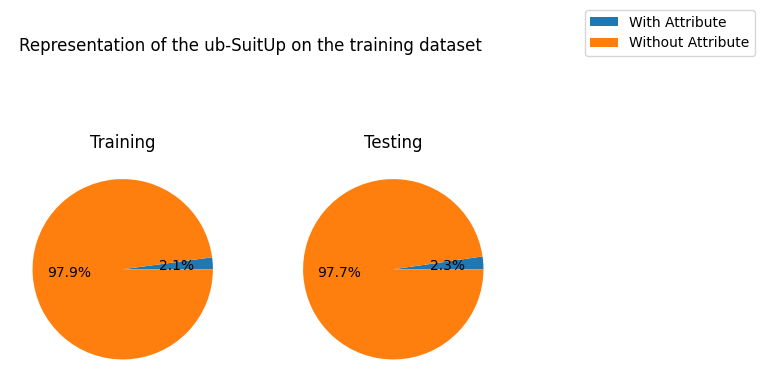

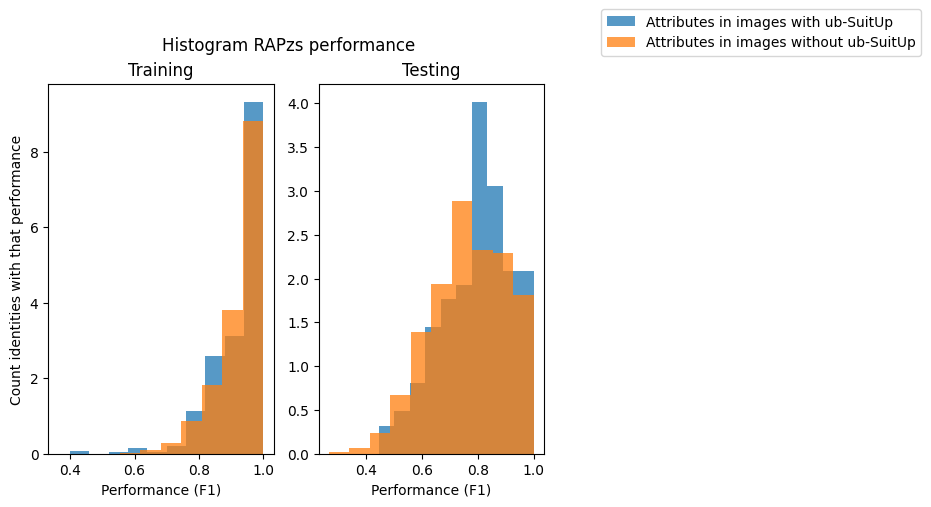

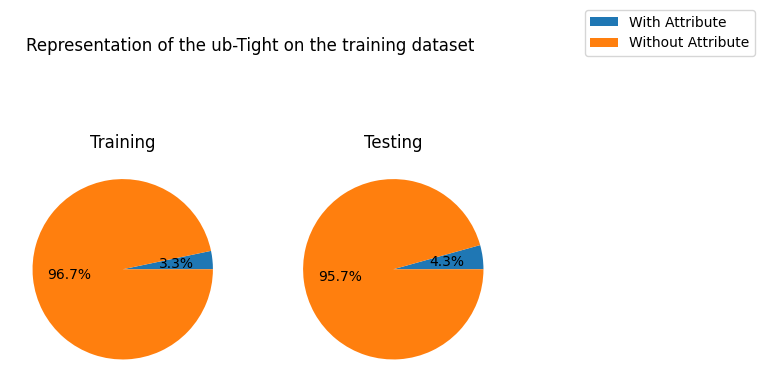

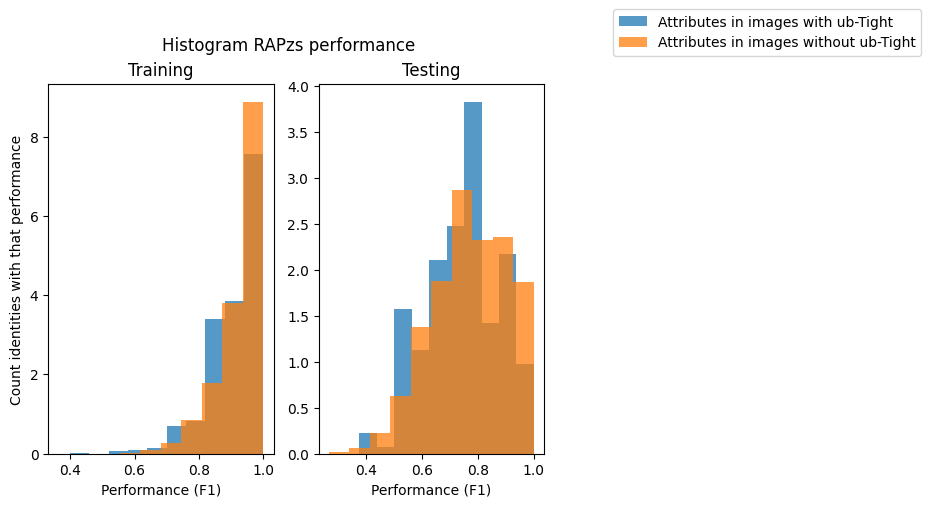

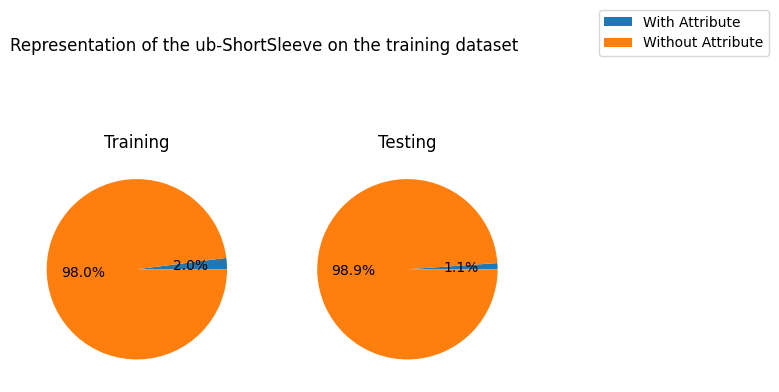

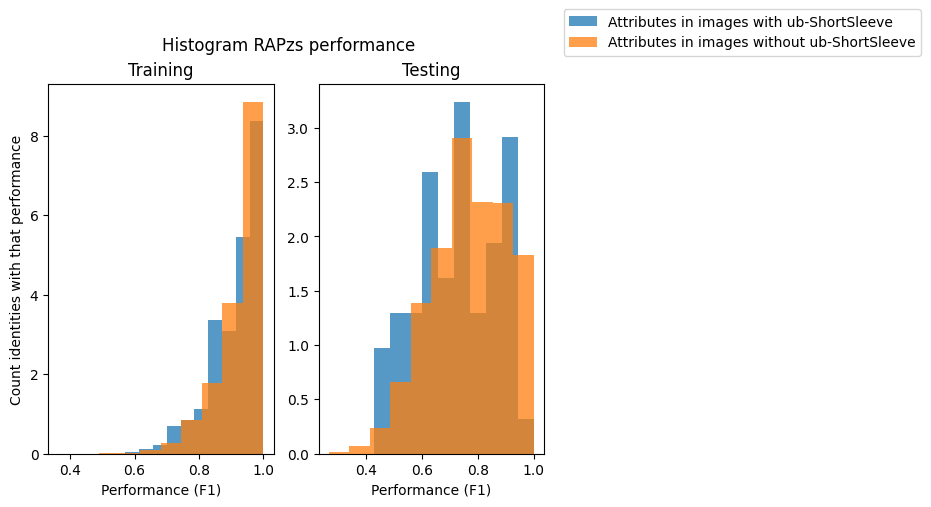

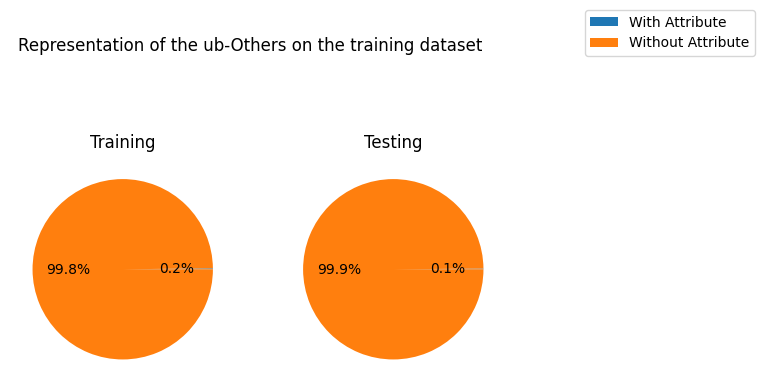

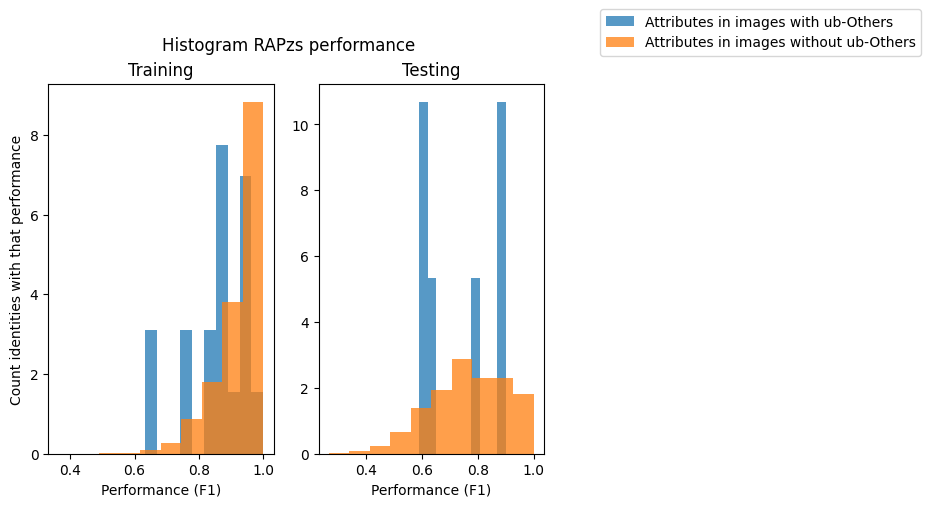

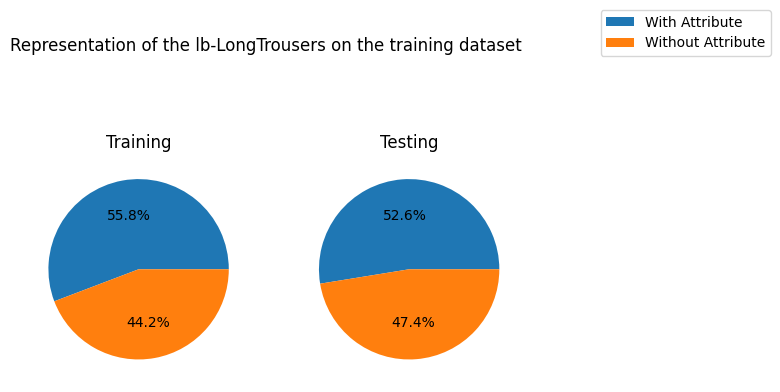

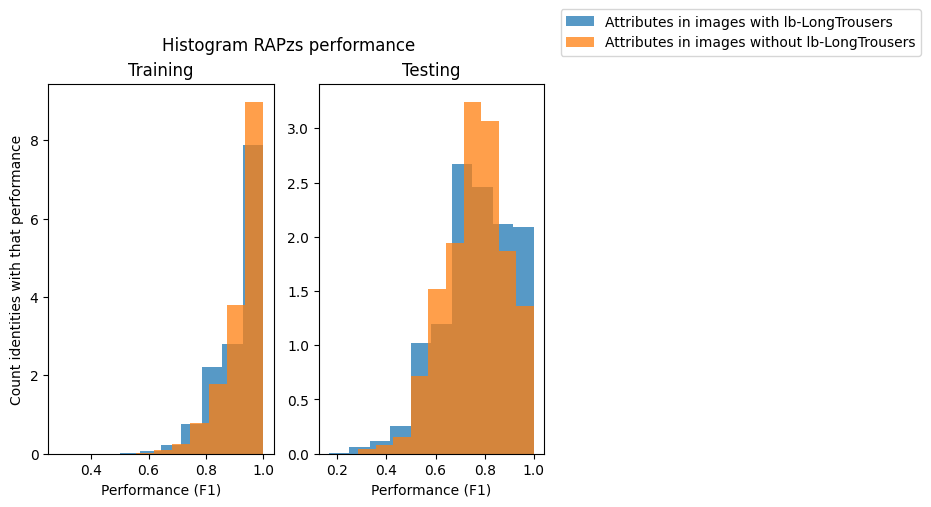

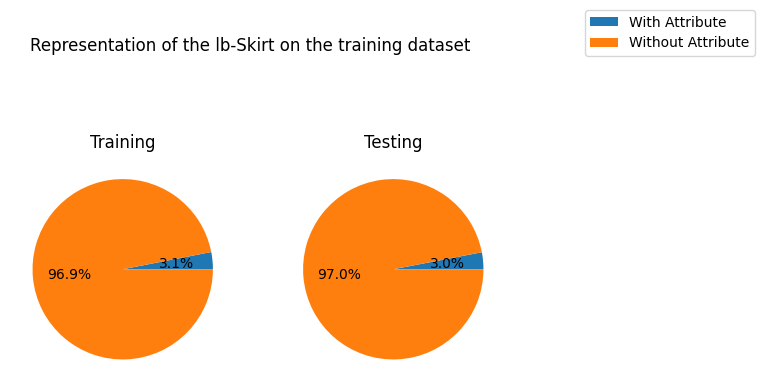

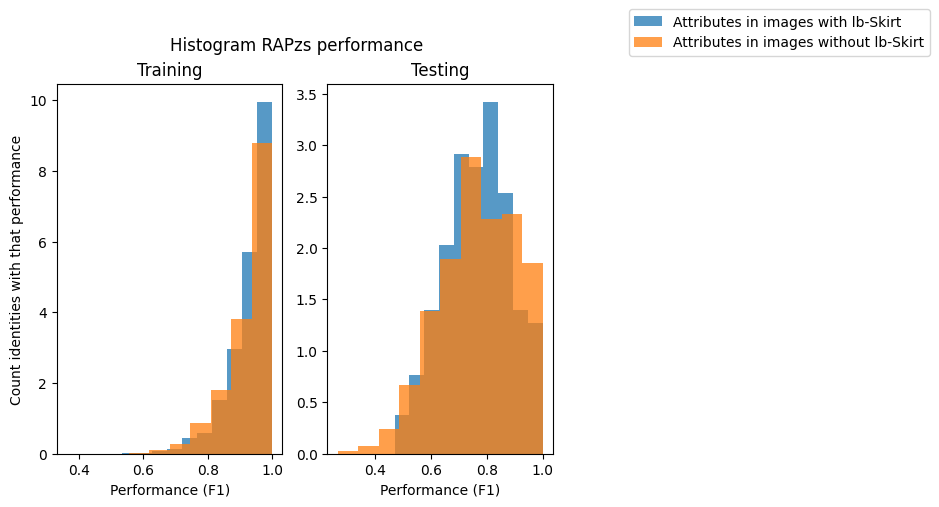

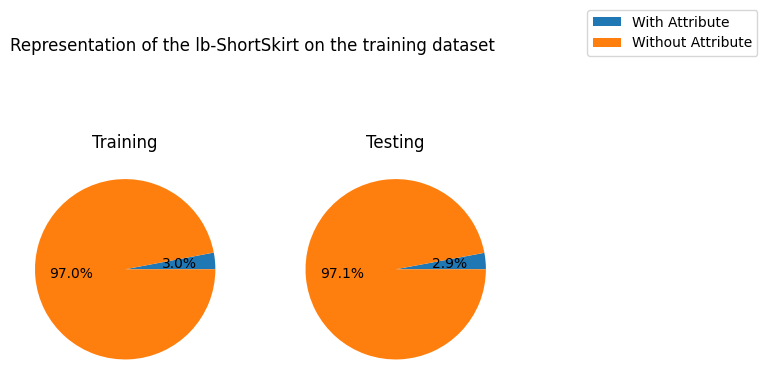

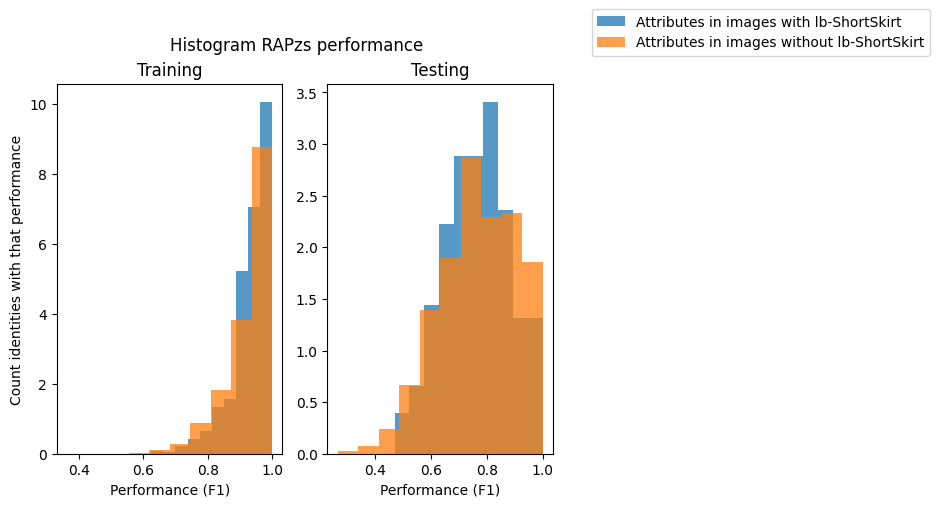

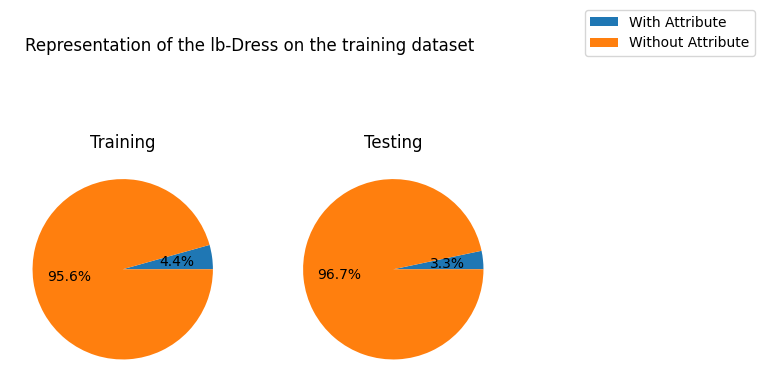

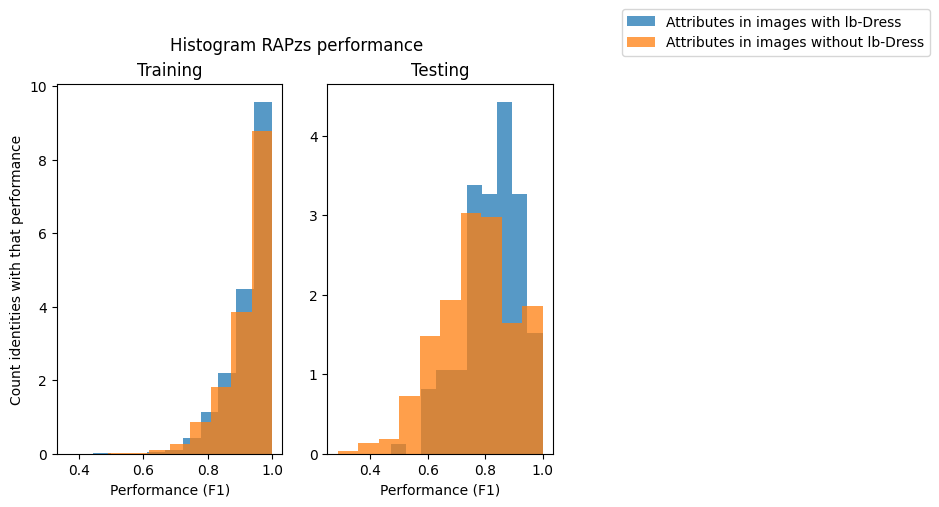

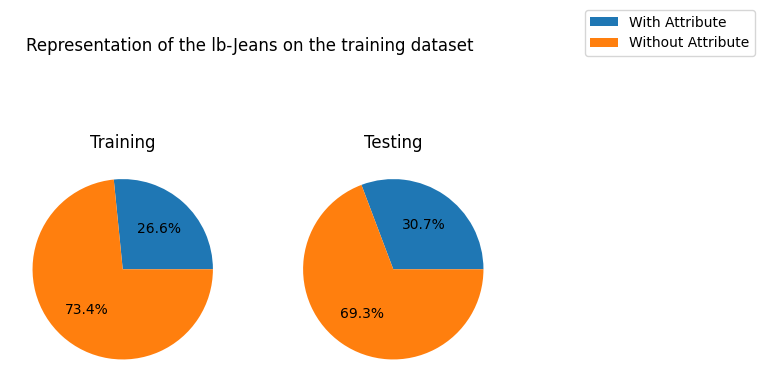

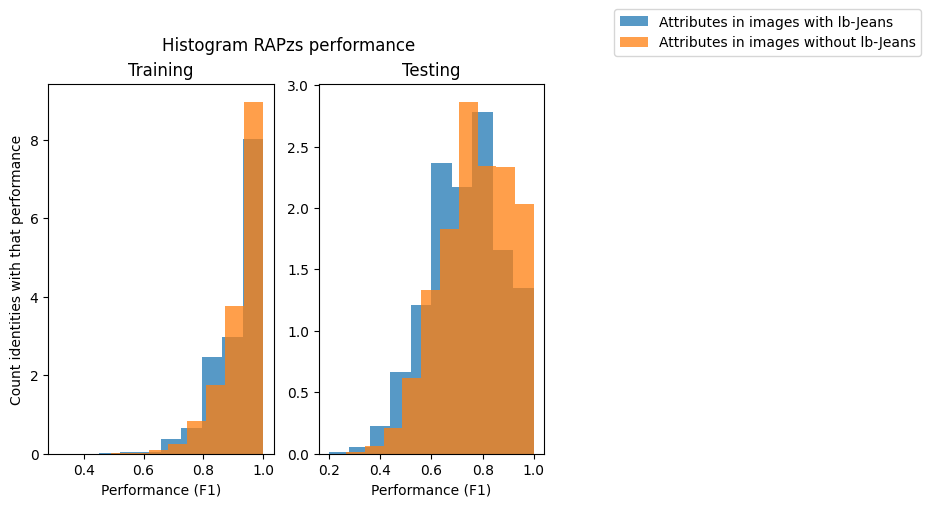

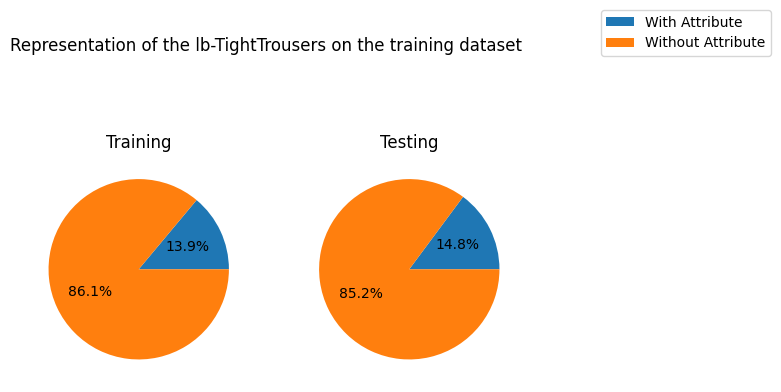

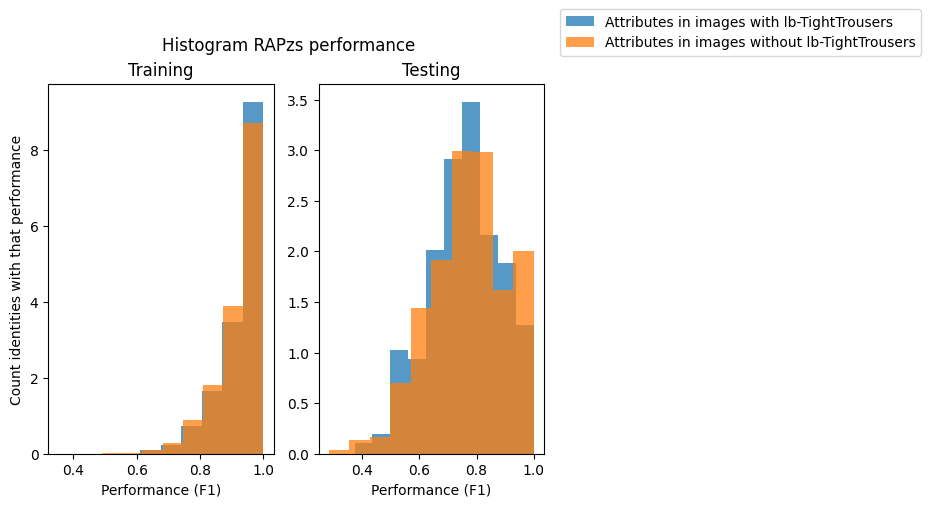

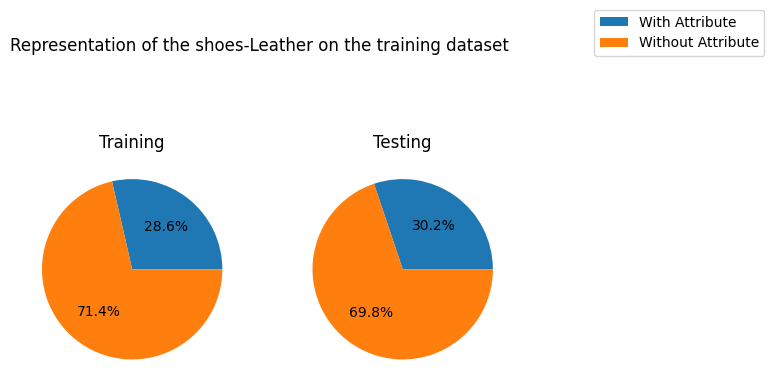

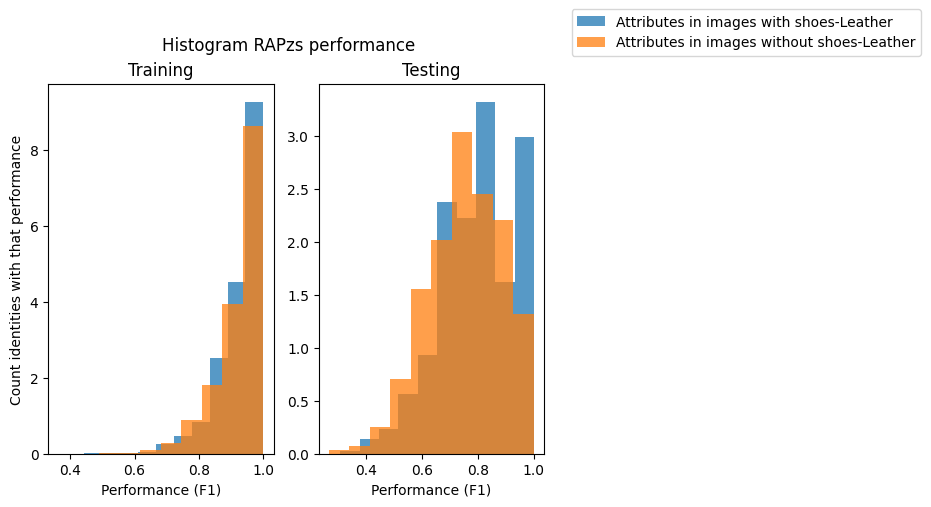

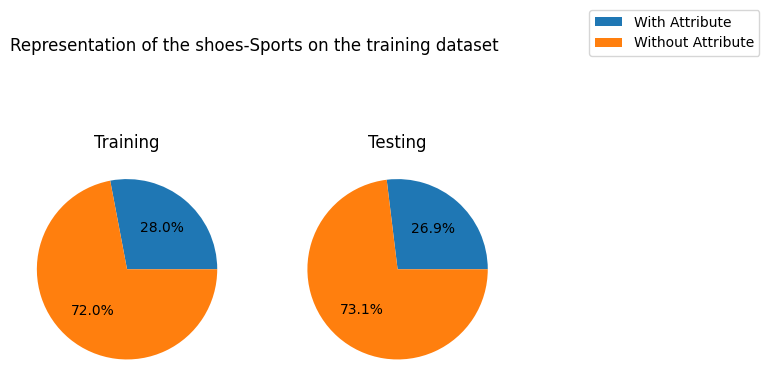

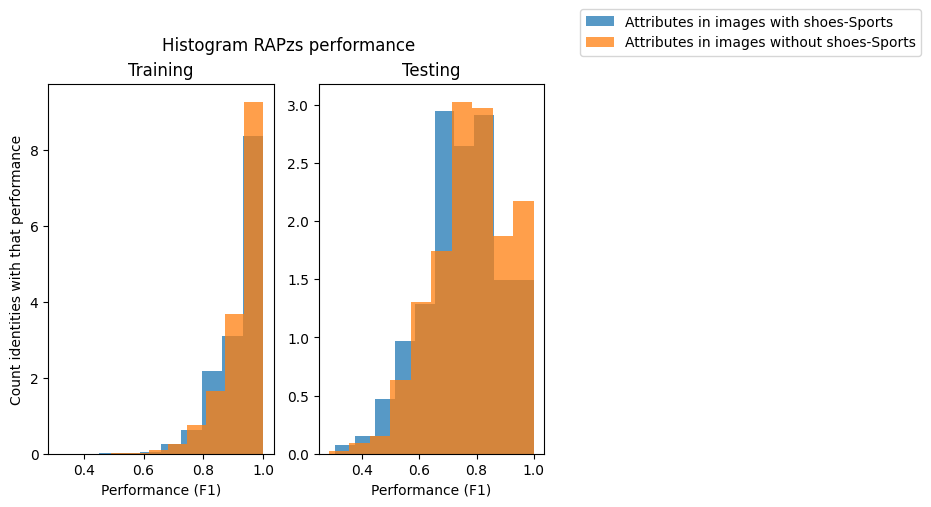

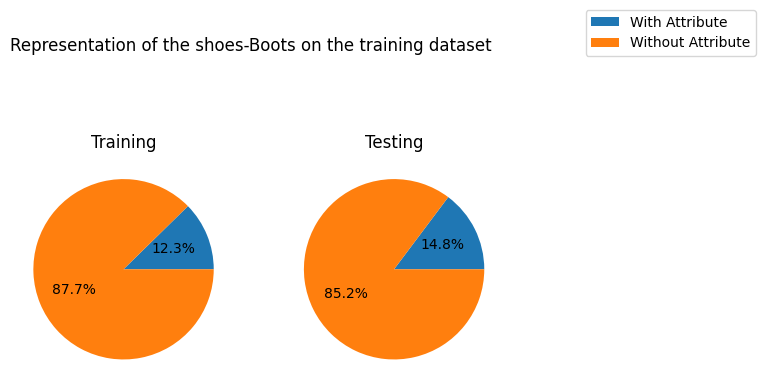

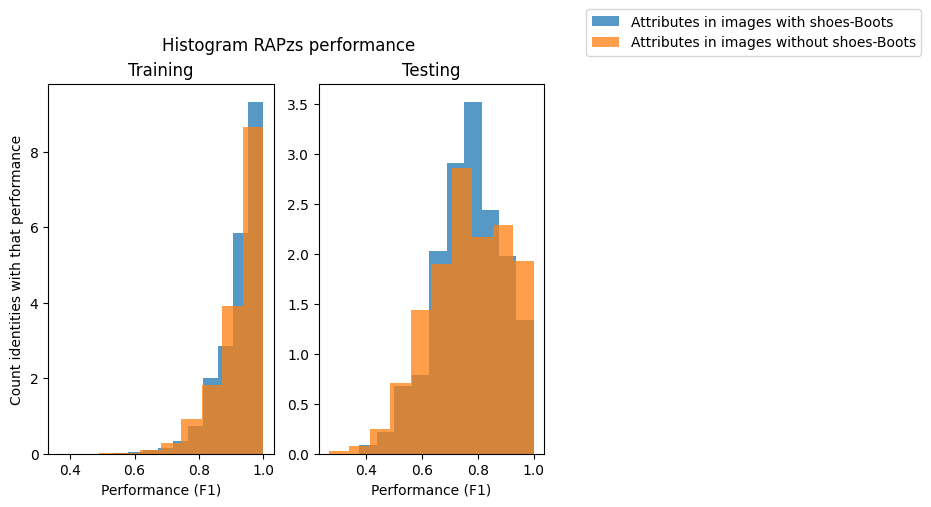

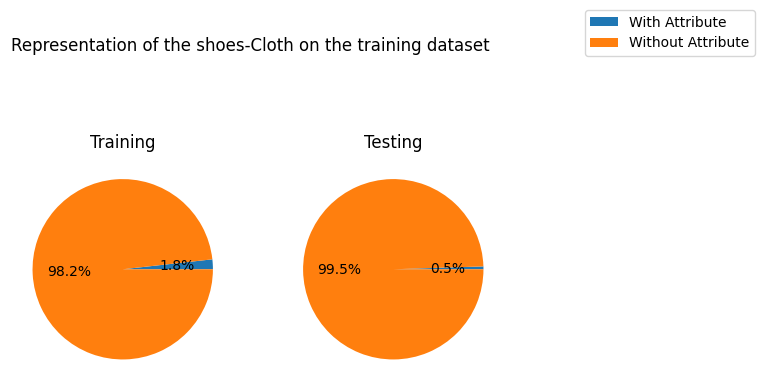

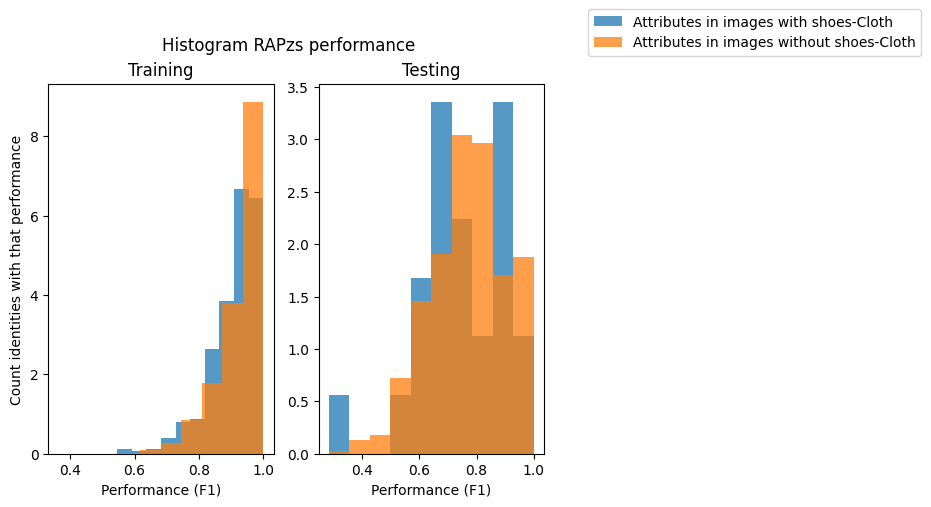

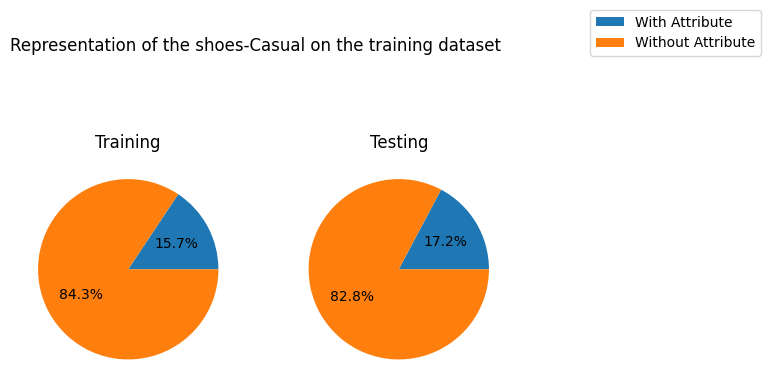

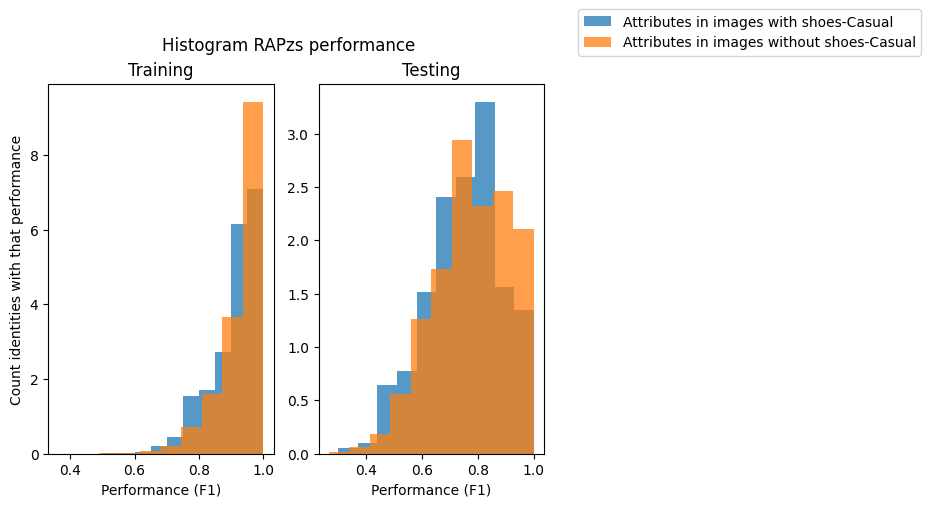

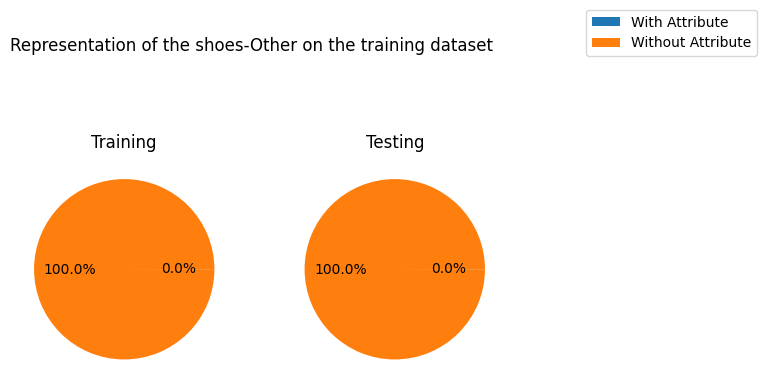

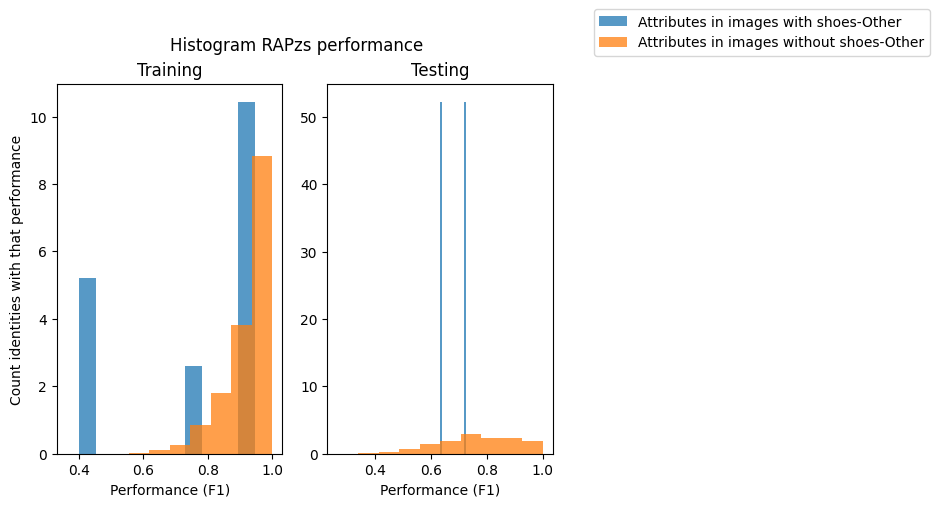

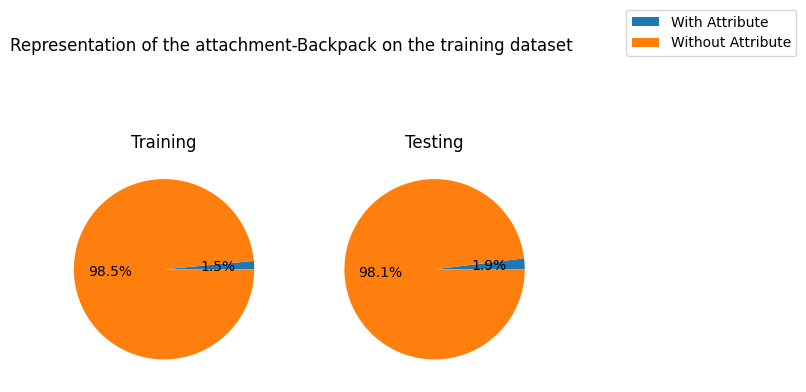

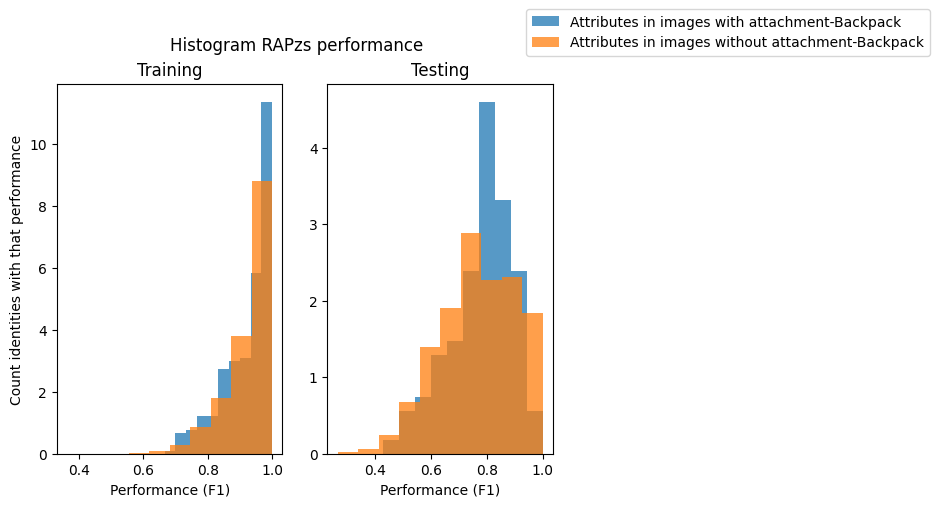

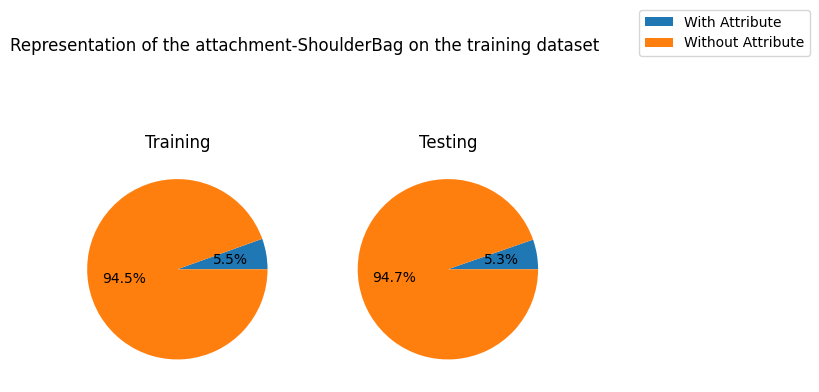

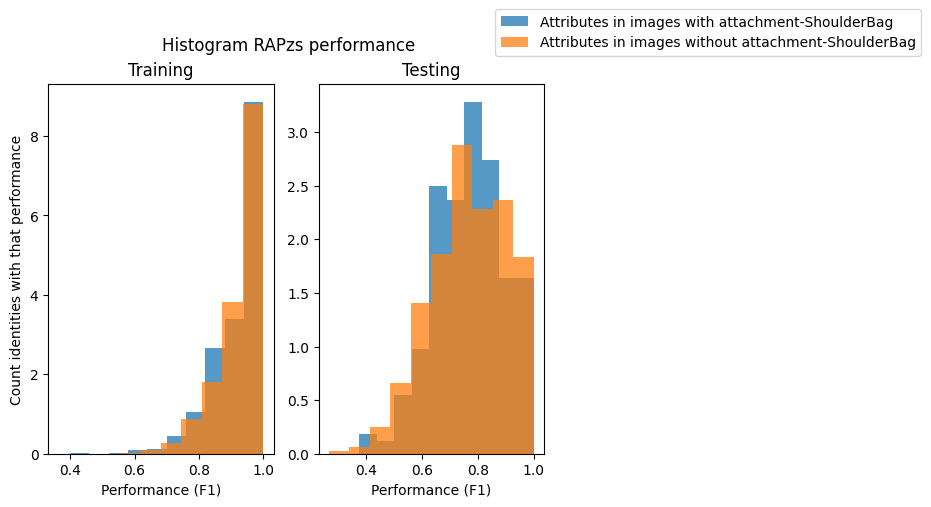

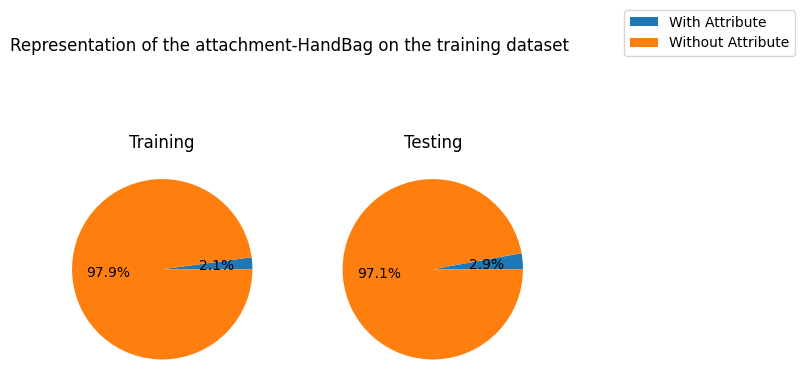

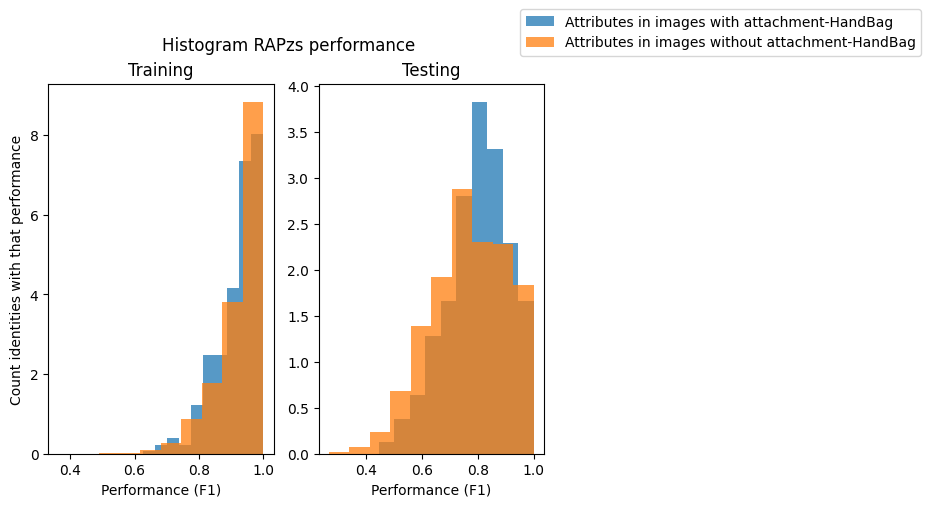

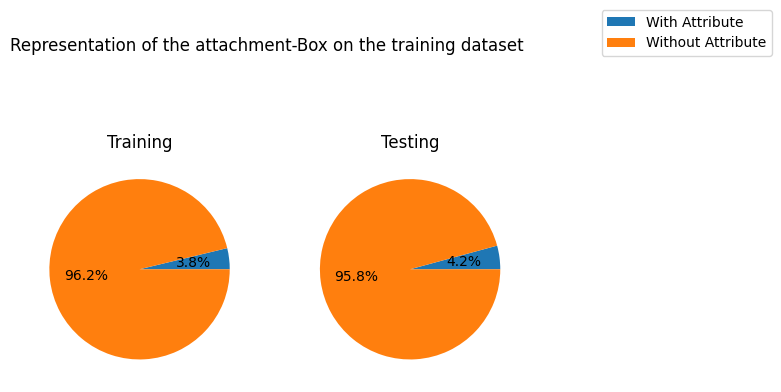

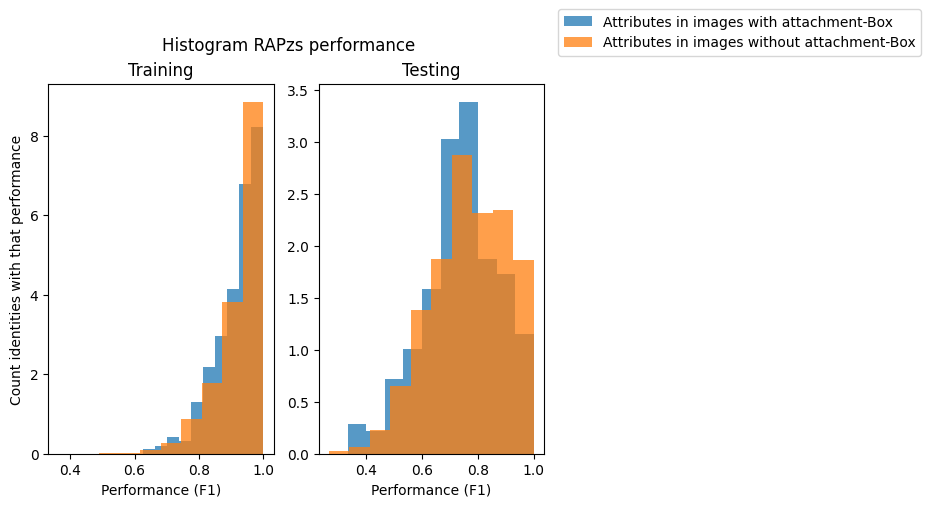

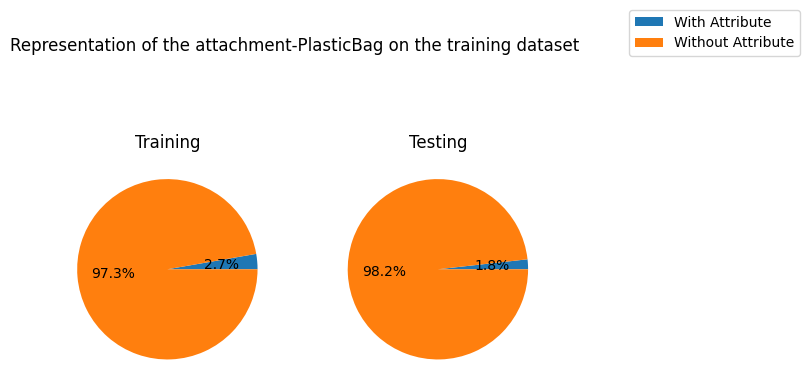

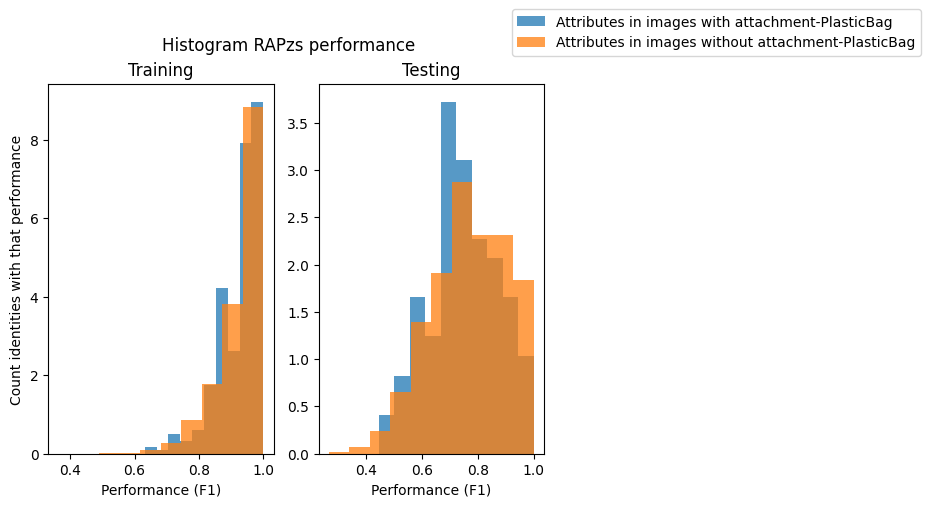

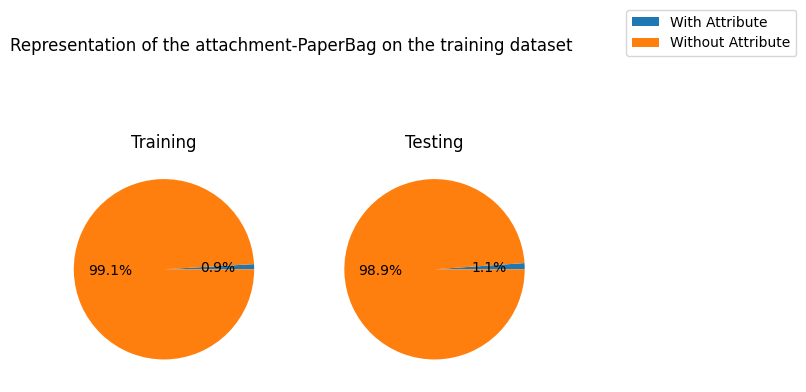

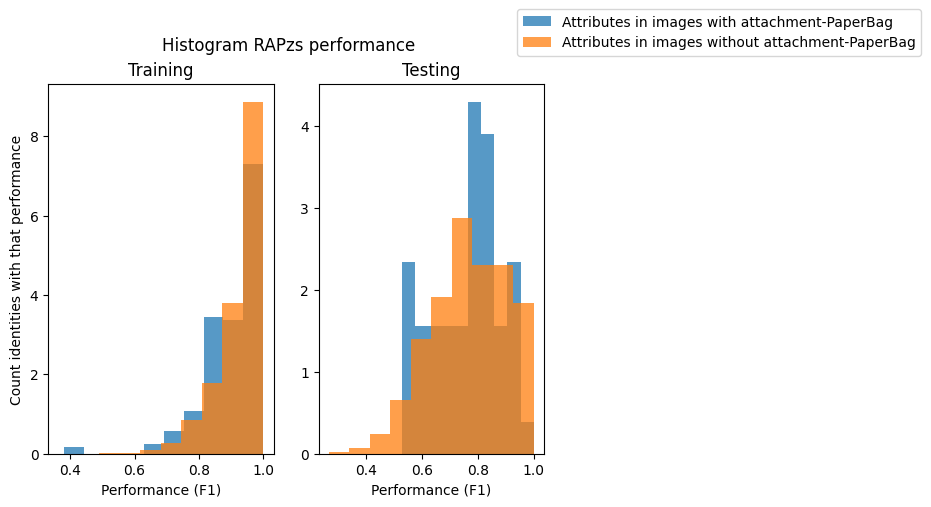

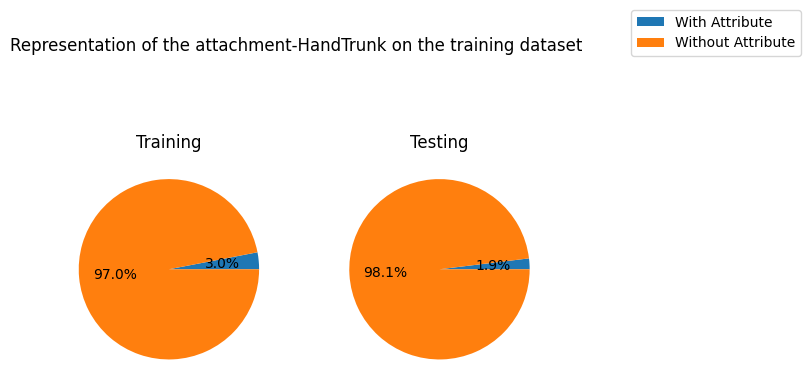

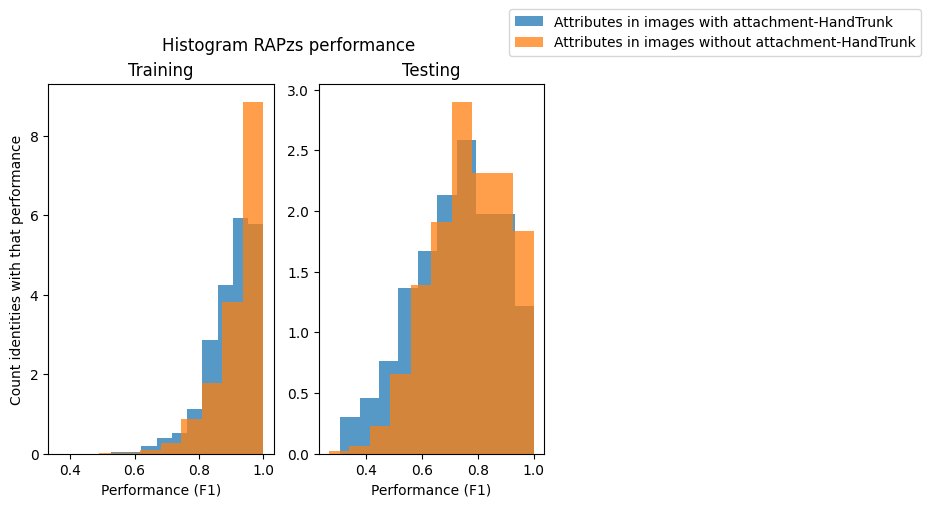

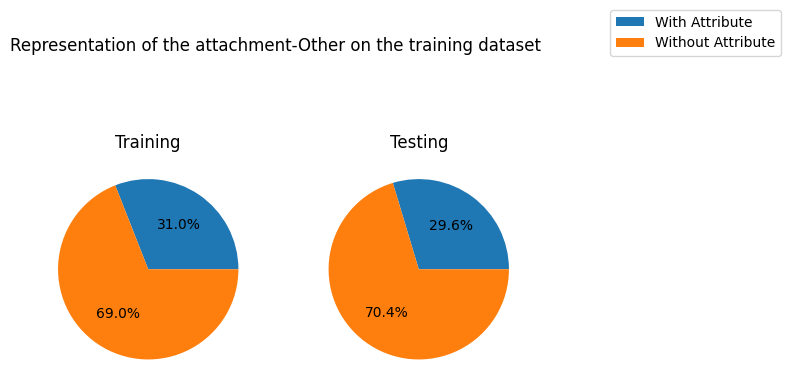

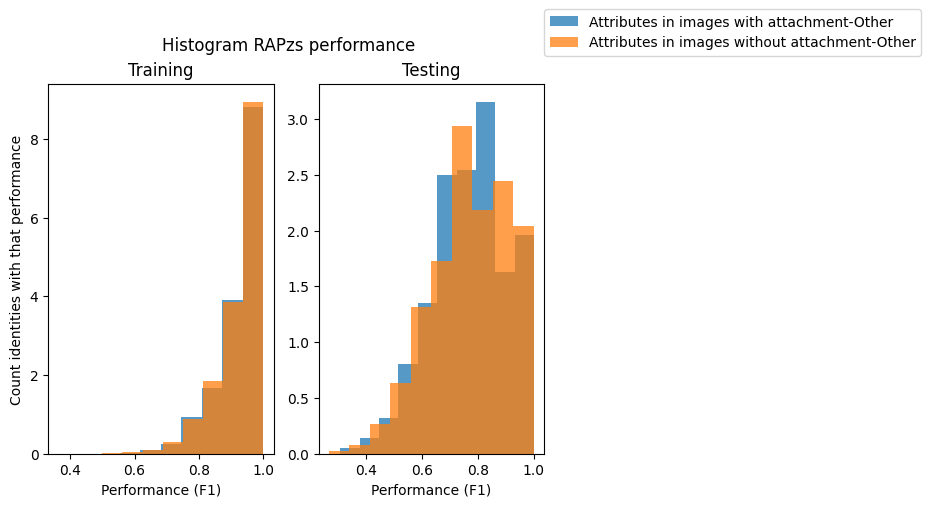

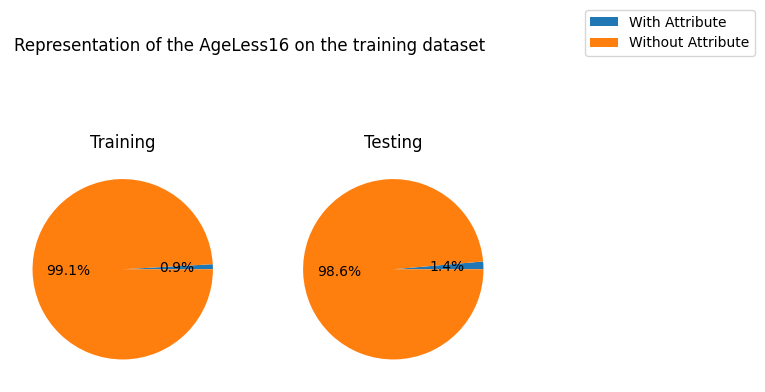

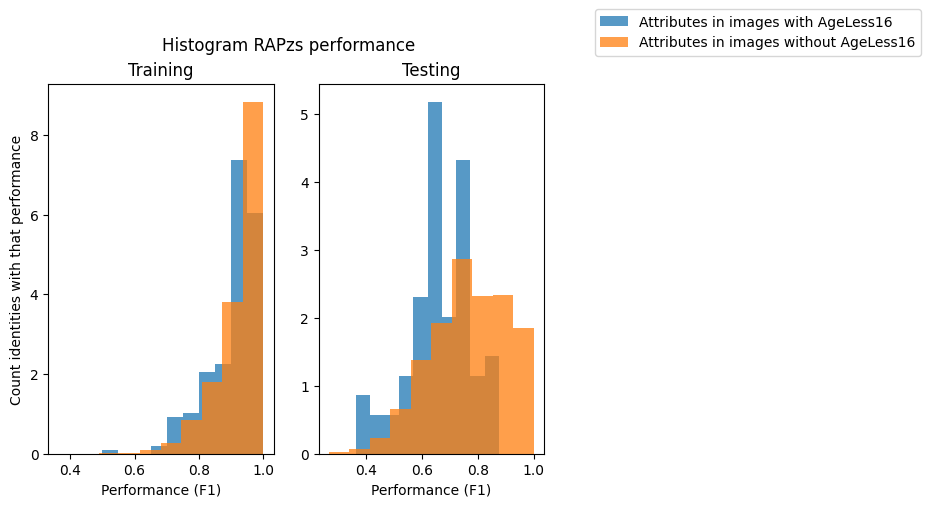

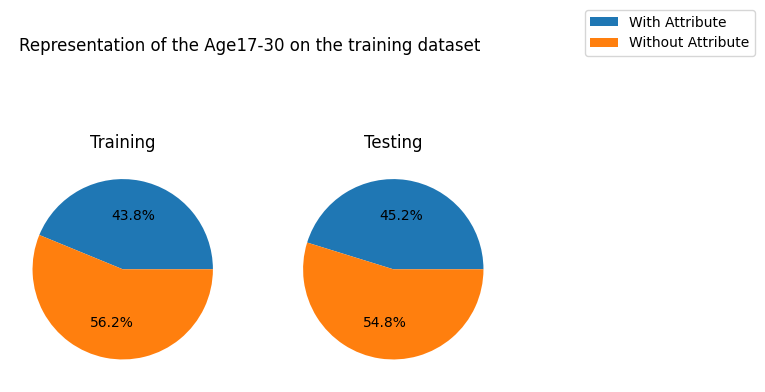

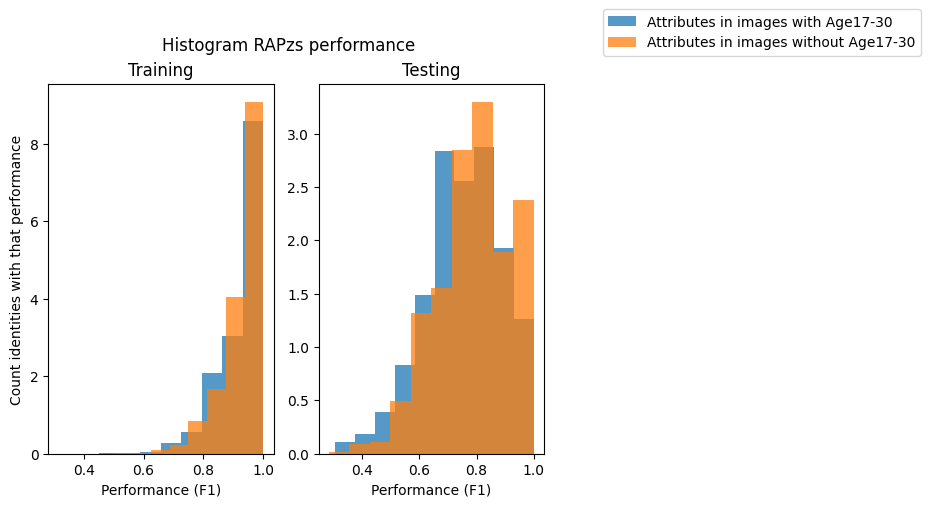

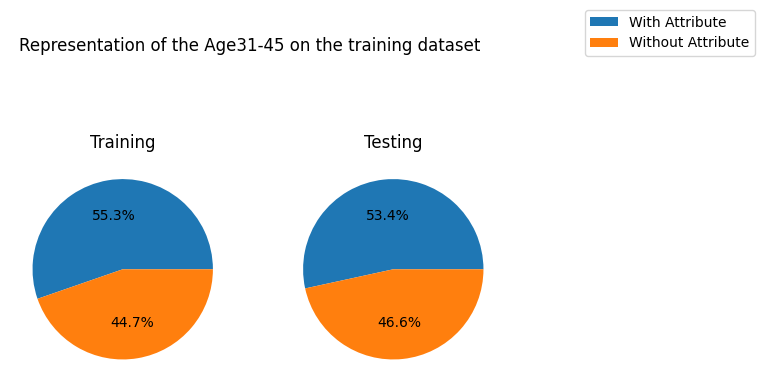

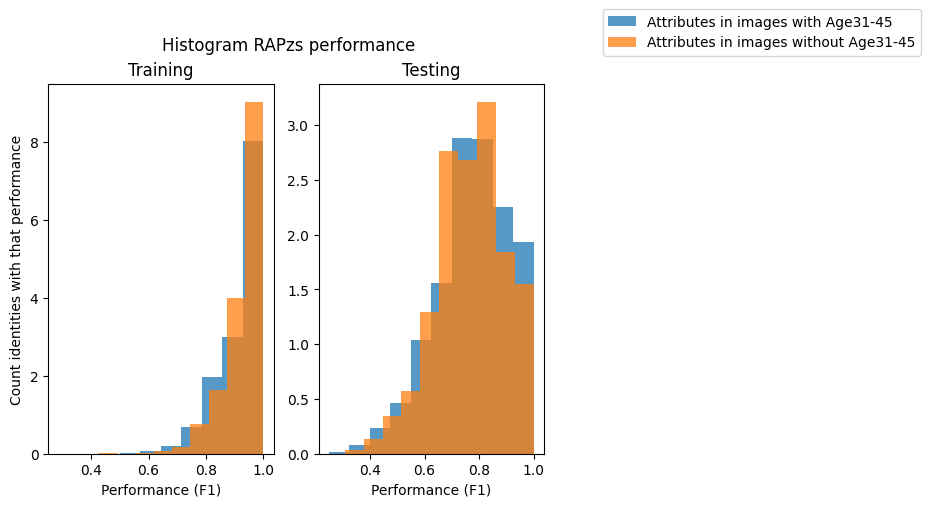

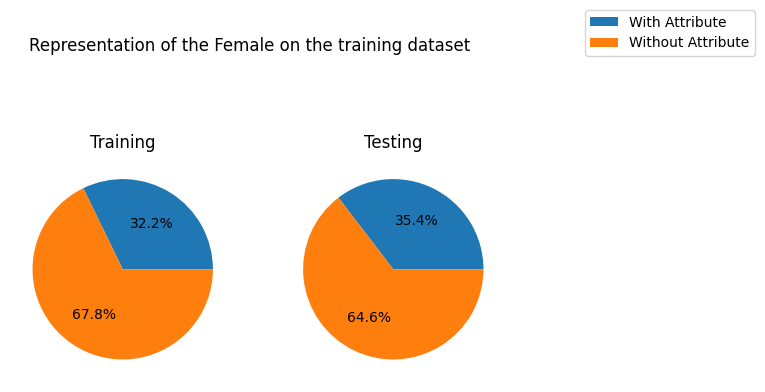

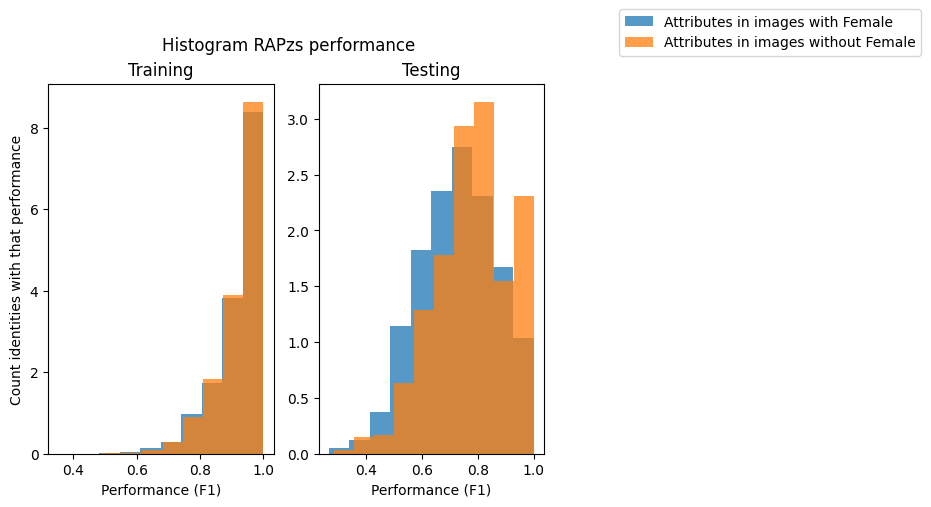

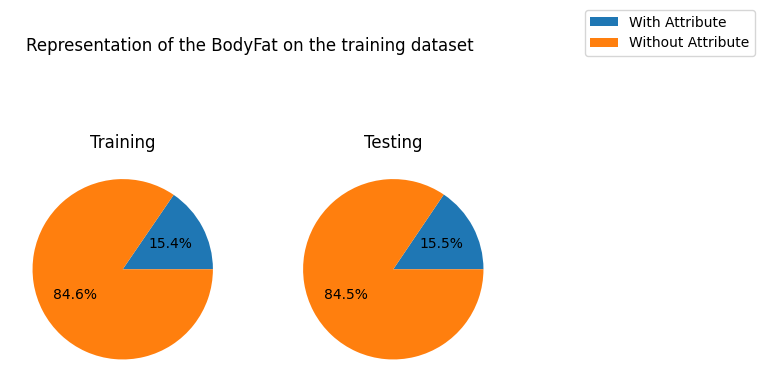

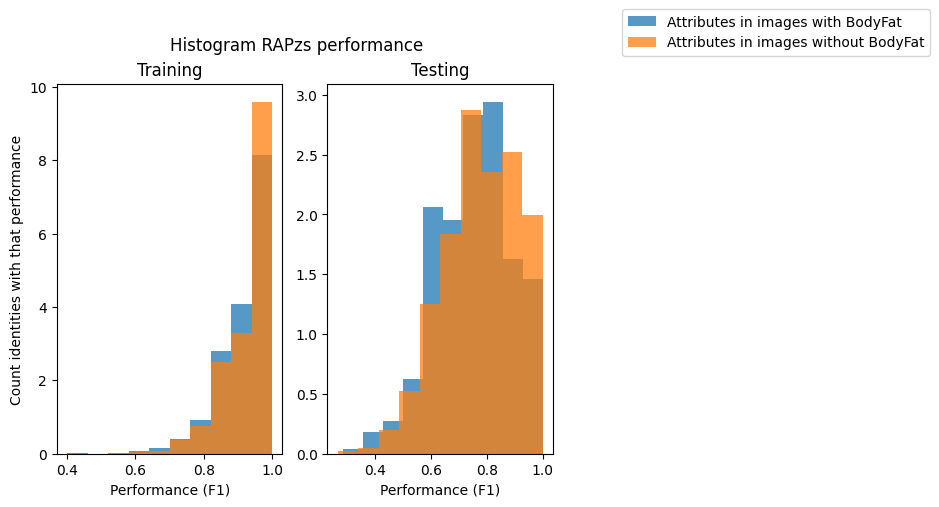

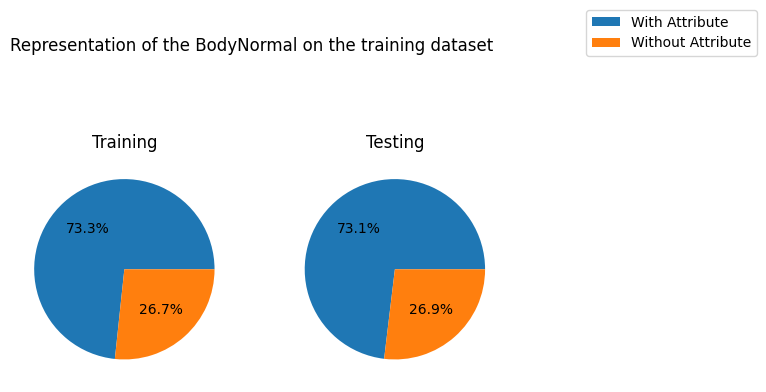

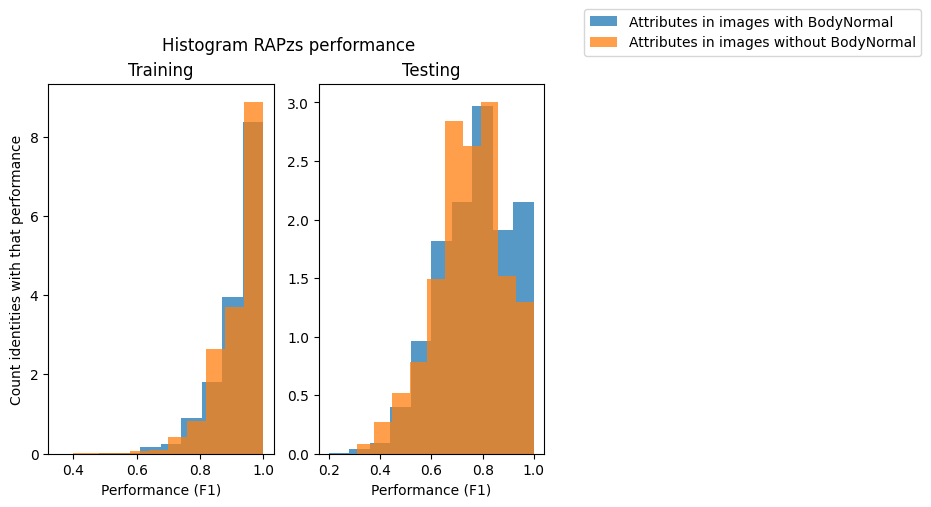

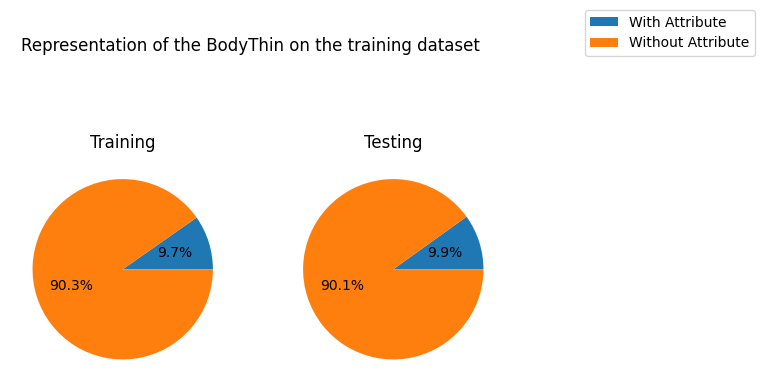

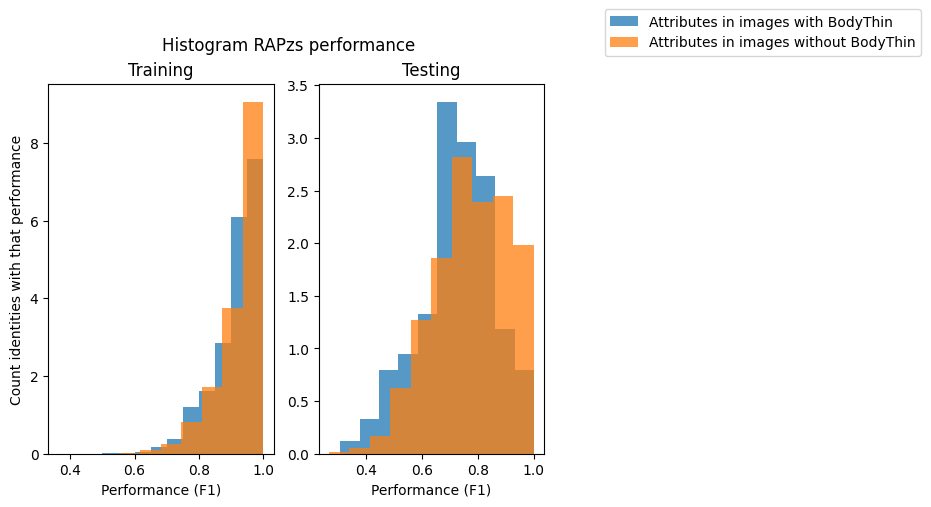

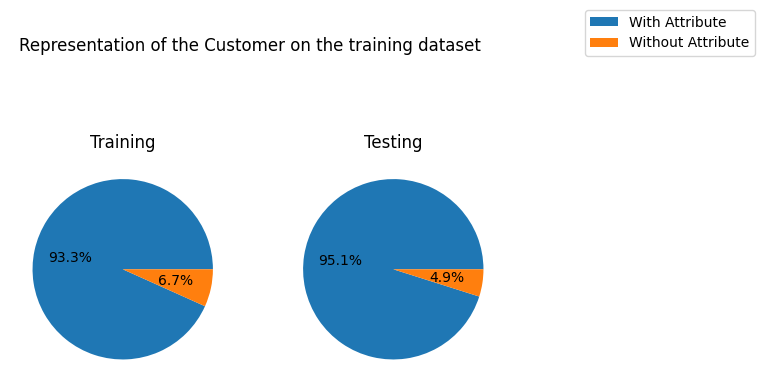

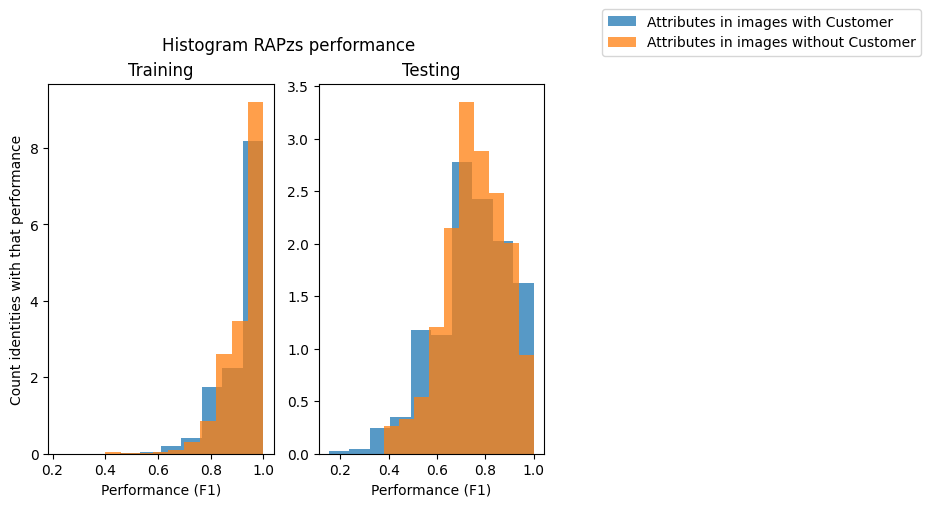

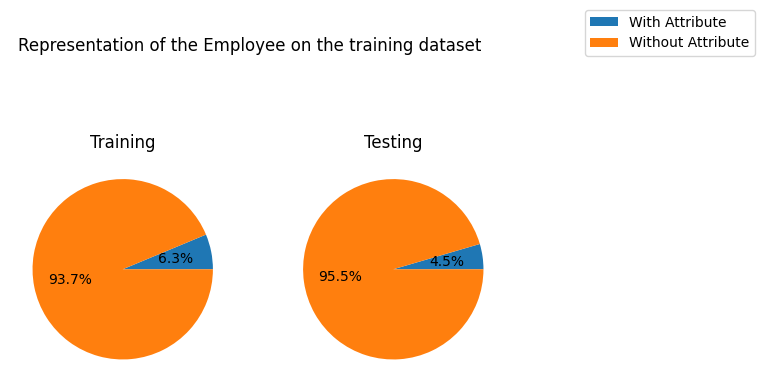

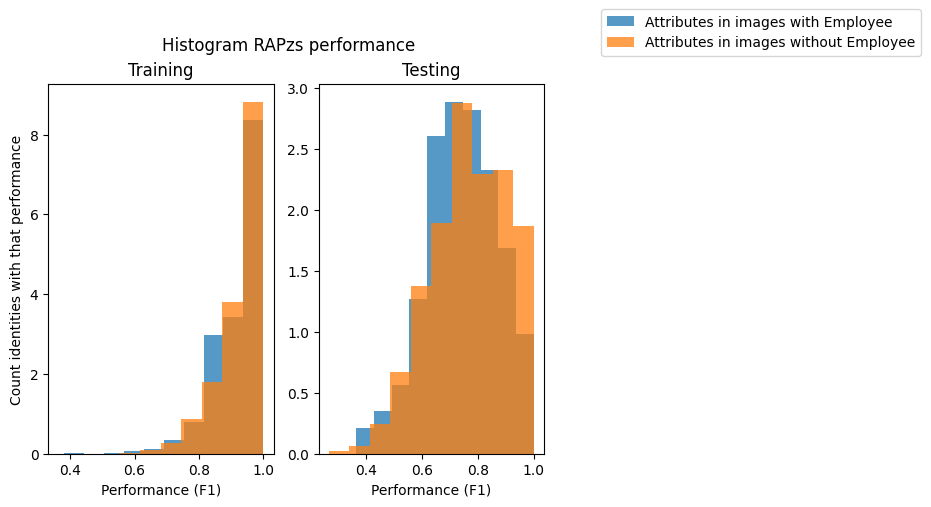

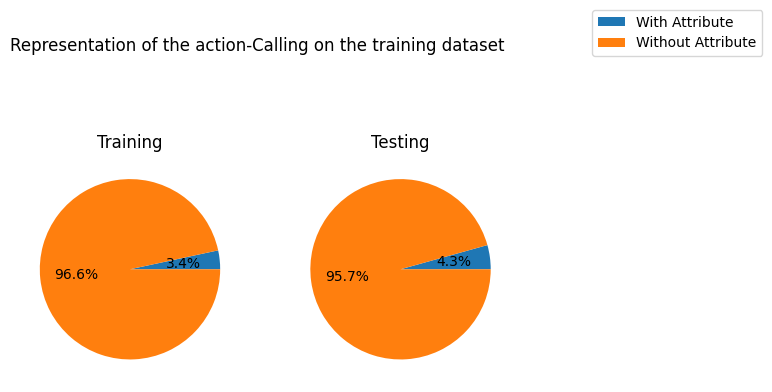

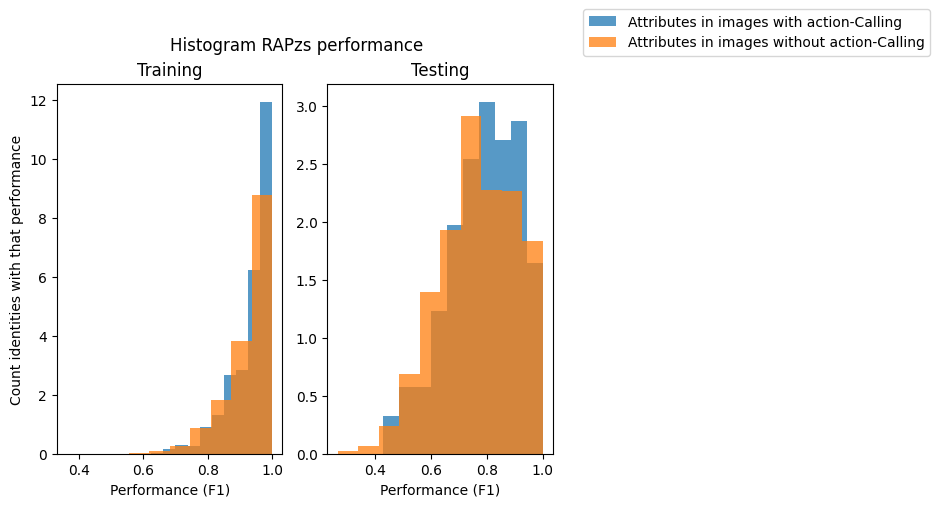

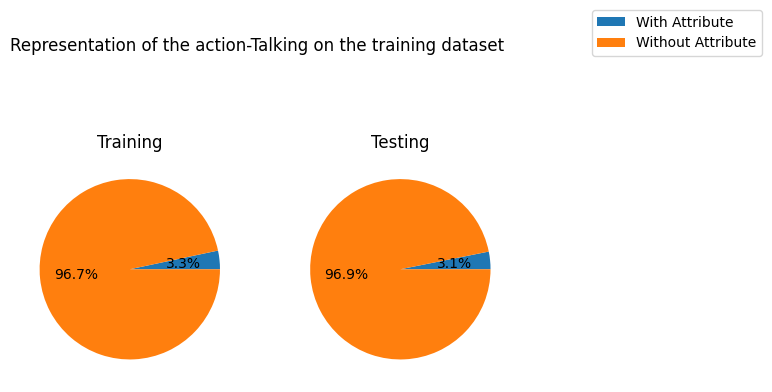

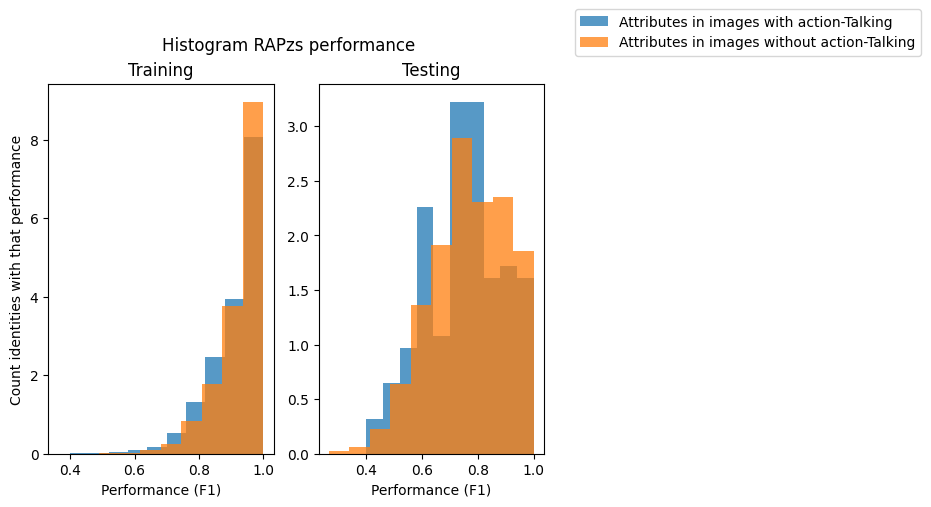

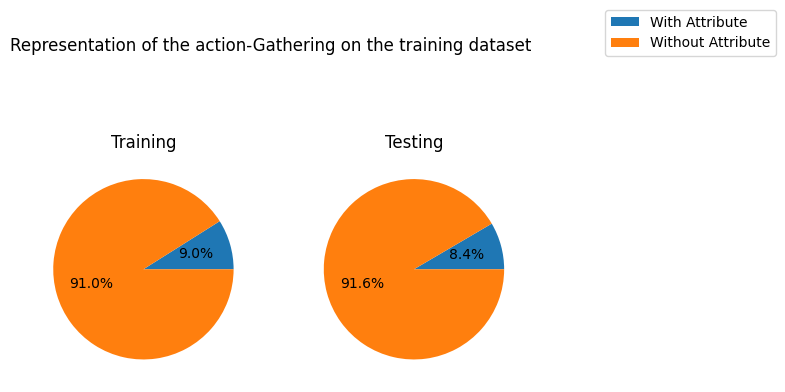

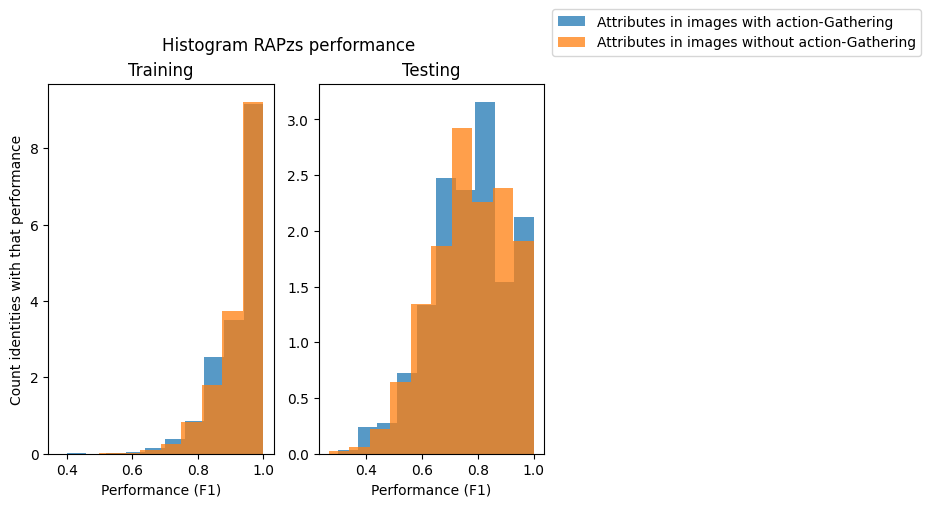

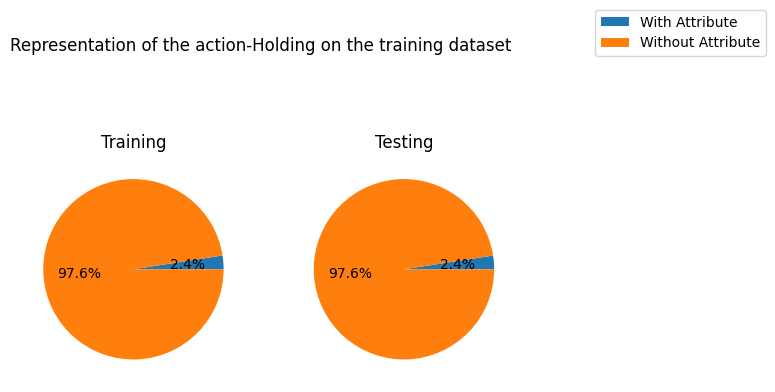

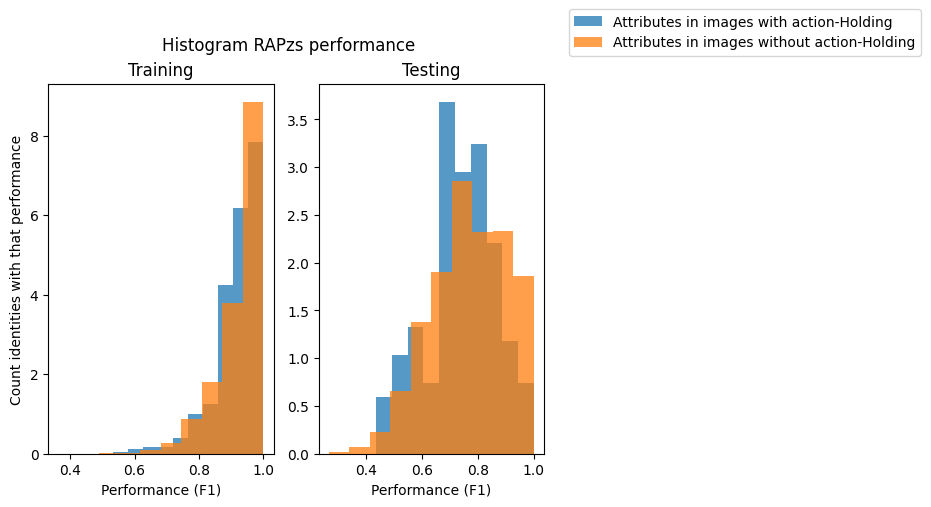

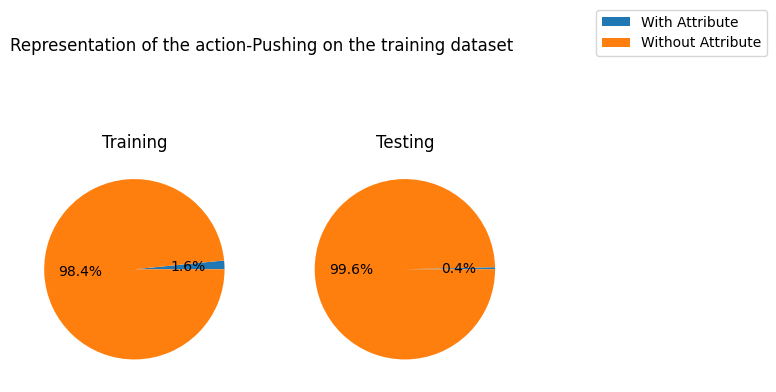

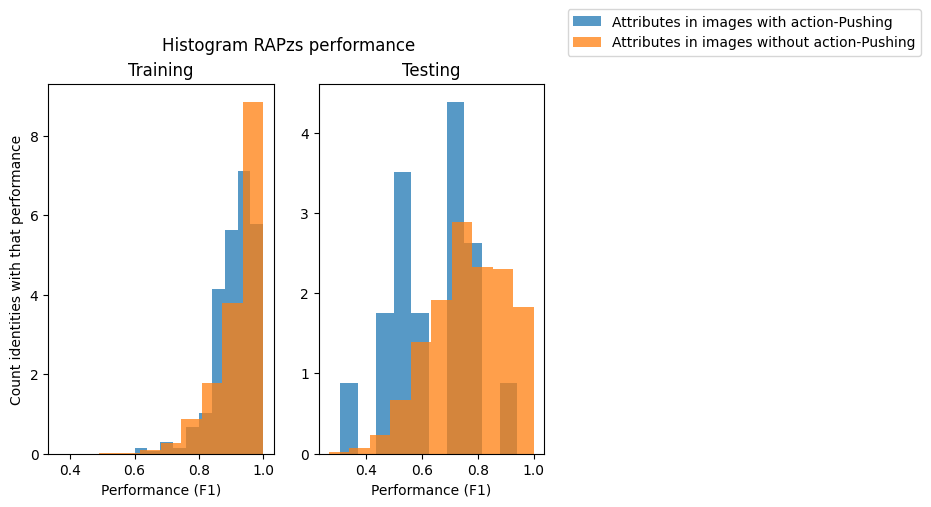

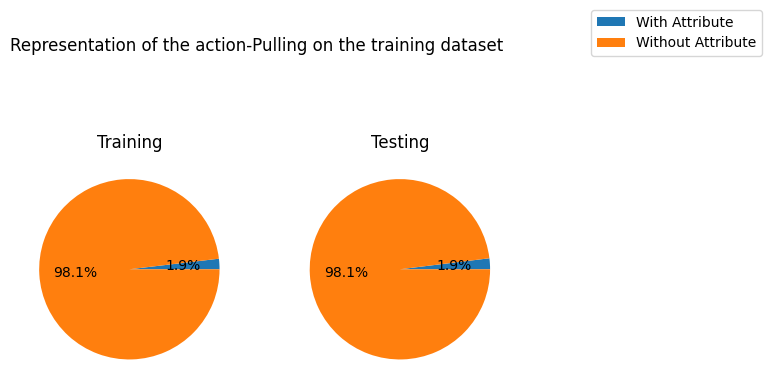

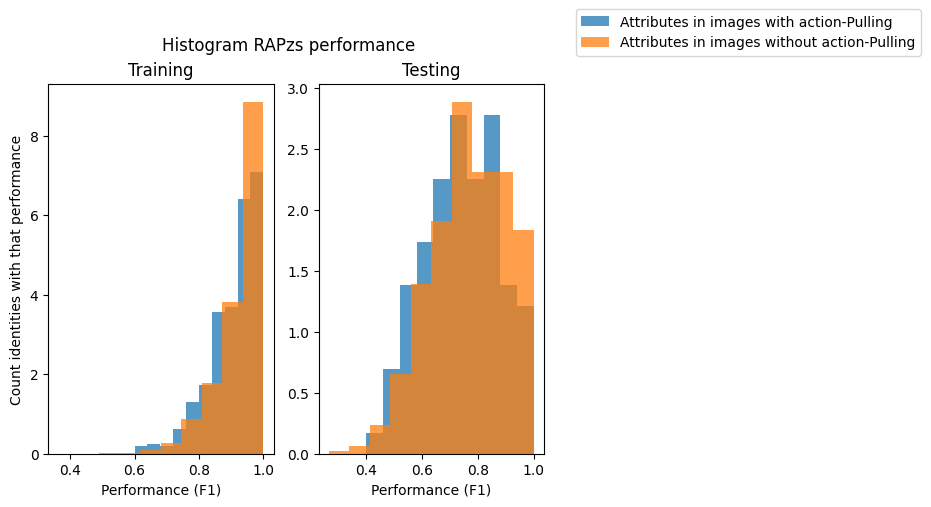

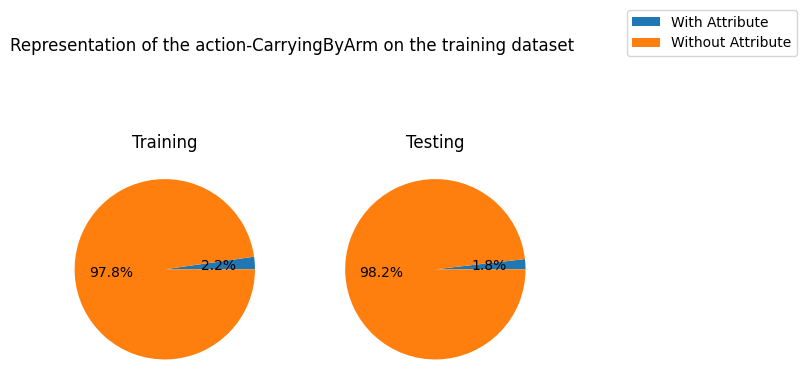

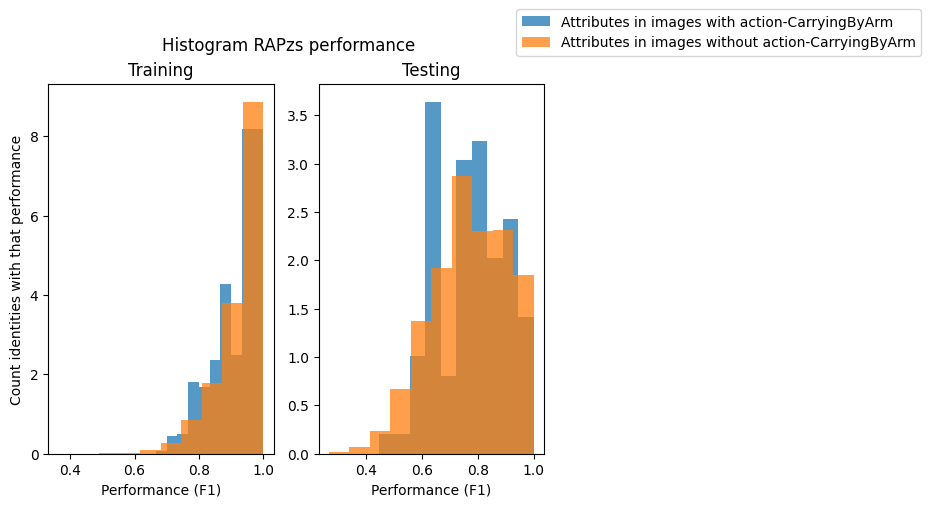

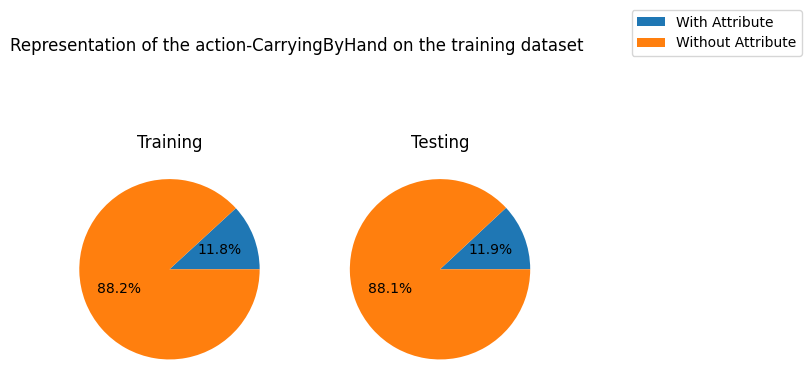

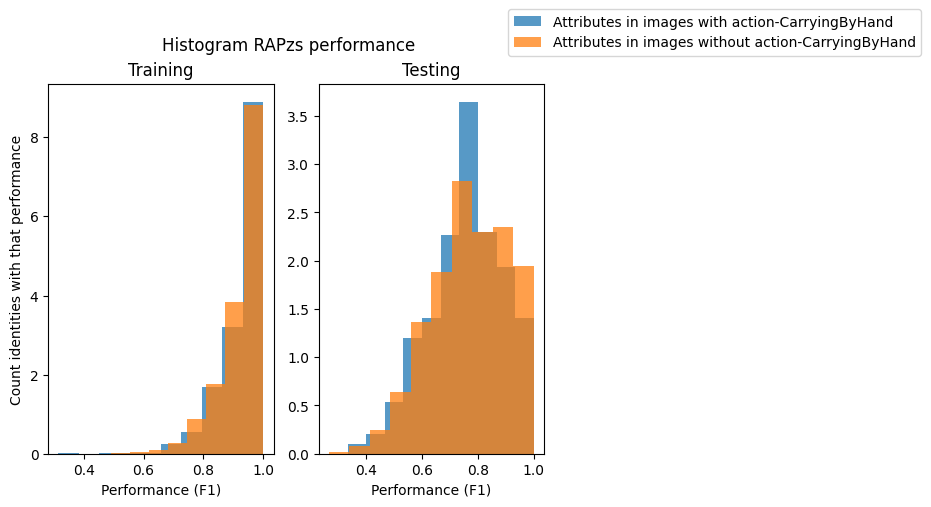

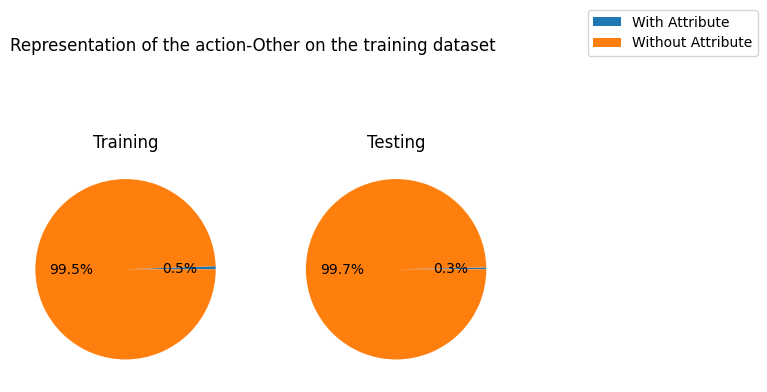

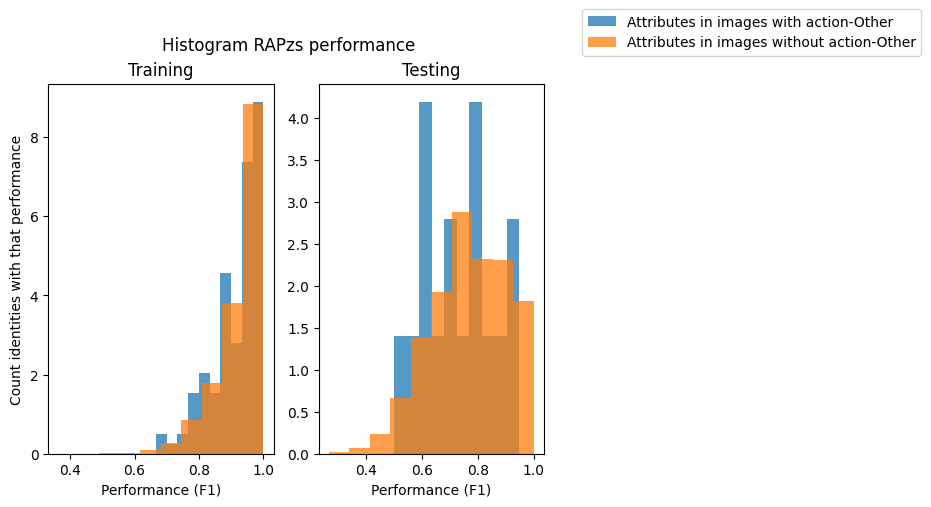

In [9]:
thresholdTop = 0.85
thresholdBot = 0.6
maxImages = 10

columns = ['Attribute', 'mean training with attribute', 'var training with attribute', 'mean training without attribute', 'var training without attribute', \
           'diff mean training', 'diff var training', \
           'mean testing with attribute', 'var testing with attribute', 'mean testing without attribute', 'var testing without attribute', \
           'diff mean testing', 'diff var testing', \
           '% With Attribute Training', '% WithOut Attribute Training', '% With Attribute Testing', '% WithOut Attribute Testing', \
           'Intersection training', 'Intersection testing']
for i in range(maxImages):
    columns.append('name training worst'+str(i))
    columns.append('resolution training worst'+str(i))

for i in range(maxImages):
    columns.append('name training best'+str(i))
    columns.append('resolution training best'+str(i))

for i in range(maxImages):
    columns.append('name testing worst'+str(i))
    columns.append('resolution testing worst'+str(i))

for i in range(maxImages):
    columns.append('name testing best'+str(i))
    columns.append('resolution testing best'+str(i))

for i in range(maxImages):
    columns.append('performance training worst'+str(i))
for i in range(maxImages):
    columns.append('performance training best'+str(i))

for i in range(maxImages):    
    columns.append('performance testing worst'+str(i))
for i in range(maxImages):    
    columns.append('performance testing best'+str(i))

dfIndentities = pd.DataFrame(columns=columns)

listIdentitiesNameTrainingWorstAllAttributes = []
listIdentitiesNameTrainingBestAllAttributes = []
listIdentitiesNameTestingWorstAllAttributes = []
listIdentitiesNameTestingBestAllAttributes = []

listIdentitiesPerfTrainingWorstAllAttributes = []
listIdentitiesPerfTrainingBestAllAttributes = []
listIdentitiesPerfTestingWorstAllAttributes = []
listIdentitiesPerfTestingBestAllAttributes = []

#attributeToAnalyze='BodyFat'
for attributeToAnalyze in listAttributesRAPzs:

    if os.path.exists(pathToSave+attributeToAnalyze) == False:
        os.mkdir(pathToSave+attributeToAnalyze)

    areaTraining, areaTesting, meanInstanceF1withAttributeTraining, varInstanceF1withAttributeTraining, \
        meanInstanceF1withOutAttributeTraining, varInstanceF1withOutAttributeTraining, meanInstanceF1withAttributeTesting, \
        varInstanceF1withAttributeTesting, meanInstanceF1withOutAttributeTesting, varInstanceF1withOutAttributeTesting, \
        dfTestingIdentitiesNameImage, dfTrainingIdentitiesNameImage, listNumTraining, listNumTesting = getAnalysisIdentitieByAttribute(attributeToAnalyze, jsonTestingGTPredicted, jsonTrainingGTPredicted, listAttributesRAPzs, jsonTrainingInstance, jsonTestingInstance)
    
    listIdentitiesNameTrainingWorst = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['name image'][:maxImages].to_list()
    listIdentitiesNameTrainingBest = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['name image'][:maxImages].to_list()
    listIdentitiesNameTestingWorst = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['name image'][:maxImages].to_list()
    listIdentitiesNameTestingBest = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['name image'][:maxImages].to_list()

    listIdentitiesPerfTrainingWorst = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['performance with attribute'][:maxImages].to_list()
    listIdentitiesPerfTrainingBest = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['performance with attribute'][:maxImages].to_list()
    listIdentitiesPerfTestingWorst = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['performance with attribute'][:maxImages].to_list()
    listIdentitiesPerfTestingBest = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['performance with attribute'][:maxImages].to_list()

# for correlation between performance and resolution
    listIdentitiesPerfTrainingWorstAll = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['performance with attribute'][:].to_list()
    listIdentitiesPerfTrainingBestAll = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['performance with attribute'][:].to_list()
    listIdentitiesPerfTestingWorstAll = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['performance with attribute'][:].to_list()
    listIdentitiesPerfTestingBestAll = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['performance with attribute'][:].to_list()

    listIdentitiesPerfTrainingWorstAllAttributes.append(listIdentitiesPerfTrainingWorstAll)
    listIdentitiesPerfTrainingBestAllAttributes.append(listIdentitiesPerfTrainingBestAll)
    listIdentitiesPerfTestingWorstAllAttributes.append(listIdentitiesPerfTestingWorstAll)
    listIdentitiesPerfTestingBestAllAttributes.append(listIdentitiesPerfTestingBestAll)

# for distribution of resolution
    listIdentitiesNameTrainingWorstAll = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['name image'][:].to_list()
    listIdentitiesNameTrainingBestAll = dfTrainingIdentitiesNameImage[dfTrainingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['name image'][:].to_list()
    listIdentitiesNameTestingWorstAll = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']<thresholdBot].sort_values(by='performance with attribute')['name image'][:].to_list()
    listIdentitiesNameTestingBestAll = dfTestingIdentitiesNameImage[dfTestingIdentitiesNameImage['performance with attribute']>thresholdTop].sort_values(by='performance with attribute')['name image'][:].to_list()

    listIdentitiesNameTrainingWorstAllAttributes.append(listIdentitiesNameTrainingWorstAll)
    listIdentitiesNameTrainingBestAllAttributes.append(listIdentitiesNameTrainingBestAll)
    listIdentitiesNameTestingWorstAllAttributes.append(listIdentitiesNameTestingWorstAll)
    listIdentitiesNameTestingBestAllAttributes.append(listIdentitiesNameTestingBestAll)


    diffMeanTraining = meanInstanceF1withAttributeTraining - meanInstanceF1withOutAttributeTraining
    diffVarTraining = varInstanceF1withAttributeTraining - varInstanceF1withOutAttributeTraining
    diffMeanTesting = meanInstanceF1withAttributeTesting - meanInstanceF1withOutAttributeTesting
    diffVarTesting = varInstanceF1withAttributeTesting - varInstanceF1withOutAttributeTesting


    newRow = [attributeToAnalyze, meanInstanceF1withAttributeTraining, varInstanceF1withAttributeTraining, \
              meanInstanceF1withOutAttributeTraining, varInstanceF1withOutAttributeTraining, \
              diffMeanTraining, diffVarTraining, \
              meanInstanceF1withAttributeTesting, \
              varInstanceF1withAttributeTesting, meanInstanceF1withOutAttributeTesting, varInstanceF1withOutAttributeTesting, \
              diffMeanTesting, diffVarTesting, \
              listNumTraining[0], listNumTraining[1], listNumTesting[0], listNumTesting[1], areaTraining, areaTesting]
    
    diffLen = maxImages - len(listIdentitiesNameTrainingWorst)
    for item in listIdentitiesNameTrainingWorst:
        i=listIdentitiesNameTrainingWorst.index(item)
        shutil.copy(pathOfDataset+item, pathToSave+attributeToAnalyze+"/imageTrainingWorst"+str(i)+typeImage)
        newRow.append(item)

        im = Image.open(pathToSave+attributeToAnalyze+"/imageTrainingWorst"+str(i)+typeImage)
        width, height = im.size
        newRow.append(width*height)

    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')
            newRow.append(0)

    diffLen = maxImages - len(listIdentitiesNameTrainingBest)
    for item in listIdentitiesNameTrainingBest:
        i=listIdentitiesNameTrainingBest.index(item)
        shutil.copy(pathOfDataset+item, pathToSave+attributeToAnalyze+"/imageTrainingBest"+str(i)+typeImage)
        newRow.append(item)

        im = Image.open(pathToSave+attributeToAnalyze+"/imageTrainingBest"+str(i)+typeImage)
        width, height = im.size
        newRow.append(width*height)

    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')
            newRow.append(0)
    
    diffLen = maxImages - len(listIdentitiesNameTestingWorst)
    for item in listIdentitiesNameTestingWorst:
        i=listIdentitiesNameTestingWorst.index(item)
        shutil.copy(pathOfDataset+item, pathToSave+attributeToAnalyze+"/imageTestingWorst"+str(i)+typeImage)
        newRow.append(item)

        im = Image.open(pathToSave+attributeToAnalyze+"/imageTestingWorst"+str(i)+typeImage)
        width, height = im.size
        newRow.append(width*height)

    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')
            newRow.append(0)
    
    diffLen = maxImages - len(listIdentitiesNameTestingBest)
    for item in listIdentitiesNameTestingBest:
        i=listIdentitiesNameTestingBest.index(item)
        shutil.copy(pathOfDataset+item, pathToSave+attributeToAnalyze+"/imageTestingBest"+str(i)+typeImage)
        newRow.append(item)

        im = Image.open(pathToSave+attributeToAnalyze+"/imageTestingBest"+str(i)+typeImage)
        width, height = im.size
        newRow.append(width*height)

    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')
            newRow.append(0)

    diffLen = maxImages - len(listIdentitiesPerfTrainingWorst)
    for item in listIdentitiesPerfTrainingWorst:
        newRow.append(item)

    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')

    diffLen = maxImages - len(listIdentitiesPerfTrainingBest)
    for item in listIdentitiesPerfTrainingBest:
        newRow.append(item)
    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')

    diffLen = maxImages - len(listIdentitiesPerfTestingWorst)
    for item in listIdentitiesPerfTestingWorst:
        newRow.append(item)
    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')

    diffLen = maxImages - len(listIdentitiesPerfTestingBest) 
    for item in listIdentitiesPerfTestingBest:
        newRow.append(item)
    if diffLen > 0:
        for i in range(diffLen):
            newRow.append('-')

    dfIndentities.loc[-1] = newRow  # adding a row
    dfIndentities.index = dfIndentities.index + 1  # shifting index
    dfIndentities = dfIndentities.sort_index()  # sorting by index



In [10]:
pathToSave

'RAPzs/'

In [11]:
dfIndentities.head(5)

Attribute  mean training with attribute  \
0           action-Other                      0.914573   
1  action-CarryingByHand                      0.926987   
2   action-CarryingByArm                      0.916668   
3         action-Pulling                      0.912083   
4         action-Pushing                      0.915623   

   var training with attribute  mean training without attribute  \
0                     0.006346                         0.931424   
1                     0.005904                         0.932027   
2                     0.005476                         0.931853   
3                     0.006636                         0.931624   
4                     0.005029                         0.931520   

   var training without attribute  diff mean training  diff var training  \
0                        0.005959           -0.016851           0.000386   
1                        0.006050           -0.005040          -0.000146   
2                        0.005966           -0.015185          -0.000491   
3                        0.005949           -0.019541           0.000686   
4                        0.005979           -0.015898          -0.000951   

   mean testing with attribute  var testing with attribute  \
0                     0.735715                    0.016548   
1                     0.752884                    0.016875   
2                     0.779349                    0.014649   
3                     0.740344                    0.017802   
4                     0.632885                    0.023991   

   mean testing without attribute  ...  performance testing best0  \
0                        0.768642  ...                        0.9   
1                        0.771639  ...                   0.857143   
2                        0.769125  ...                   0.857143   
3                        0.769248  ...                   0.857143   
4                        0.769058  ...                   0.941176   

   performance testing best1  performance testing best2  \
0                   0.941176                   0.947368   
1                   0.857143                   0.857143   
2                   0.857143                      0.875   
3                   0.869565                      0.875   
4                          -                          -   

  performance testing best3 performance testing best4  \
0                         -                         -   
1                  0.857143                  0.857143   
2                     0.875                     0.875   
3                     0.875                     0.875   
4                         -                         -   

  performance testing best5 performance testing best6  \
0                         -                         -   
1                  0.857143                  0.857143   
2                     0.875                  0.888889   
3                     0.875                     0.875   
4                         -                         -   

  performance testing best7 performance testing best8  \
0                         -                         -   
1                  0.857143                  0.857143   
2                  0.888889                  0.888889   
3                     0.875                  0.888889   
4                         -                         -   

  performance testing best9  
0                         -  
1                  0.857143  
2                  0.888889  
3                  0.888889  
4                         -  

[5 rows x 139 columns]

In [12]:
columns

['Attribute',
 'mean training with attribute',
 'var training with attribute',
 'mean training without attribute',
 'var training without attribute',
 'diff mean training',
 'diff var training',
 'mean testing with attribute',
 'var testing with attribute',
 'mean testing without attribute',
 'var testing without attribute',
 'diff mean testing',
 'diff var testing',
 '% With Attribute Training',
 '% WithOut Attribute Training',
 '% With Attribute Testing',
 '% WithOut Attribute Testing',
 'Intersection training',
 'Intersection testing',
 'name training worst0',
 'resolution training worst0',
 'name training worst1',
 'resolution training worst1',
 'name training worst2',
 'resolution training worst2',
 'name training worst3',
 'resolution training worst3',
 'name training worst4',
 'resolution training worst4',
 'name training worst5',
 'resolution training worst5',
 'name training worst6',
 'resolution training worst6',
 'name training worst7',
 'resolution training worst7',
 'name 

In [13]:
# means vars and diffs
columnsForMeansVarsAndDiffs = ['Attribute',
 'mean training with attribute',
 'var training with attribute',
 'mean training without attribute',
 'var training without attribute',
 'diff mean training',
 'diff var training',
 'mean testing with attribute',
 'var testing with attribute',
 'mean testing without attribute',
 'var testing without attribute',
 'diff mean testing',
 'diff var testing']
# intersections
columnsForIntersections = ['Attribute','Intersection training',
 'Intersection testing']

# resolutions
columnsForResolutionsTraining = ['Attribute']
for i in range(maxImages):
    columnsForResolutionsTraining.append('resolution training best'+str(i))
    columnsForResolutionsTraining.append('resolution training worst'+str(i))
    

columnsForResolutionsTesting= ['Attribute']
for i in range(maxImages):
    columnsForResolutionsTesting.append('resolution testing best'+str(i))
    columnsForResolutionsTesting.append('resolution testing worst'+str(i))

In [14]:
dfIndentities[columnsForMeansVarsAndDiffs].to_csv(pathToSave+'resumeIdentitiesMeansVars.csv')
dfIndentities[columnsForIntersections].to_csv(pathToSave+'resumeIdentitiesIntersections.csv')
dfIndentities[columnsForResolutionsTraining].to_csv(pathToSave+'resumeIdentitiesResolutionTraining.csv')
dfIndentities[columnsForResolutionsTesting].to_csv(pathToSave+'resumeIdentitiesResolutionTesting.csv')

In [15]:
import cv2

In [19]:
def getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes):
    # get index of the attribute
    indexAttribute = listAttributes.index(attributeToAnalyze)

    # get list name images of the index
    listNameTestingBest = listIdentitiesNameTestingBestAllAttributes[indexAttribute]
    listNameTestingWorst = listIdentitiesNameTestingWorstAllAttributes[indexAttribute]
    listNameTrainingBest = listIdentitiesNameTrainingBestAllAttributes[indexAttribute]
    listNameTrainingWorst = listIdentitiesNameTrainingWorstAllAttributes[indexAttribute]

    # create list for each list of resolutions
    listNameTestingBestResolutions = []
    listNameTestingWorstResolutions = []
    listNameTrainingBestResolutions = []
    listNameTrainingWorstResolutions = []

    # create list for each list of colors
    listNameTestingBestColorR = []
    listNameTestingBestColorG = []
    listNameTestingBestColorB = []

    listNameTestingWorstColorR = []
    listNameTestingWorstColorG = []
    listNameTestingWorstColorB = []

    listNameTrainingBestColorR = []
    listNameTrainingBestColorG = []
    listNameTrainingBestColorB = []

    listNameTrainingWorstColorR = []
    listNameTrainingWorstColorG = []
    listNameTrainingWorstColorB = []

    # for each list 
    for nameImage in listNameTestingBest:
        # get image
        im = Image.open(pathOfDataset+nameImage)

        img = cv2.imread(pathOfDataset+nameImage)
        histrB = cv2.calcHist([img],[0],None,[256],[0,256])
        histrG = cv2.calcHist([img],[1],None,[256],[0,256])
        histrR = cv2.calcHist([img],[2],None,[256],[0,256])

        if len(listNameTestingBestColorB) == 0:
            listNameTestingBestColorB = histrB
            listNameTestingBestColorG = histrG
            listNameTestingBestColorR = histrR
        else:
            listNameTestingBestColorB = [ item1 + item2 for item1, item2 in zip(histrB, listNameTestingBestColorB)]
            listNameTestingBestColorG = [ item1 + item2 for item1, item2 in zip(histrG, listNameTestingBestColorG)]
            listNameTestingBestColorR = [ item1 + item2 for item1, item2 in zip(histrR, listNameTestingBestColorR)]


        width, height = im.size
        # save resolution
        listNameTestingBestResolutions.append(width*height)
        
    for nameImage in listNameTestingWorst:
        # get image
        im = Image.open(pathOfDataset+nameImage)
        width, height = im.size
        # save resolution
        listNameTestingWorstResolutions.append(width*height)

        img = cv2.imread(pathOfDataset+nameImage)
        histrB = cv2.calcHist([img],[0],None,[256],[0,256])
        histrG = cv2.calcHist([img],[1],None,[256],[0,256])
        histrR = cv2.calcHist([img],[2],None,[256],[0,256])

        if len(listNameTestingWorstColorB) == 0:
            listNameTestingWorstColorB = histrB
            listNameTestingWorstColorG = histrG
            listNameTestingWorstColorR = histrR
        else:
            listNameTestingWorstColorB = [ item1 + item2 for item1, item2 in zip(histrB, listNameTestingWorstColorB)]
            listNameTestingWorstColorG = [ item1 + item2 for item1, item2 in zip(histrG, listNameTestingWorstColorG)]
            listNameTestingWorstColorR = [ item1 + item2 for item1, item2 in zip(histrR, listNameTestingWorstColorR)]

    for nameImage in listNameTrainingBest:
        # get image
        im = Image.open(pathOfDataset+nameImage)
        width, height = im.size
        # save resolution
        listNameTrainingBestResolutions.append(width*height)

        img = cv2.imread(pathOfDataset+nameImage)
        histrB = cv2.calcHist([img],[0],None,[256],[0,256])
        histrG = cv2.calcHist([img],[1],None,[256],[0,256])
        histrR = cv2.calcHist([img],[2],None,[256],[0,256])

        if len(listNameTrainingBestColorB) == 0:
            listNameTrainingBestColorB = histrB
            listNameTrainingBestColorG = histrG
            listNameTrainingBestColorR = histrR
        else:
            listNameTrainingBestColorB = [ item1 + item2 for item1, item2 in zip(histrB, listNameTrainingBestColorB)]
            listNameTrainingBestColorG = [ item1 + item2 for item1, item2 in zip(histrG, listNameTrainingBestColorG)]
            listNameTrainingBestColorR = [ item1 + item2 for item1, item2 in zip(histrR, listNameTrainingBestColorR)]

    for nameImage in listNameTrainingWorst:
        # get image
        im = Image.open(pathOfDataset+nameImage)
        width, height = im.size
        # save resolution
        listNameTrainingWorstResolutions.append(width*height)

        img = cv2.imread(pathOfDataset+nameImage)
        histrB = cv2.calcHist([img],[0],None,[256],[0,256])
        histrG = cv2.calcHist([img],[1],None,[256],[0,256])
        histrR = cv2.calcHist([img],[2],None,[256],[0,256])

        if len(listNameTrainingWorstColorB) == 0:
            listNameTrainingWorstColorB = histrB
            listNameTrainingWorstColorG = histrG
            listNameTrainingWorstColorR = histrR
        else:
            listNameTrainingWorstColorB = [ item1 + item2 for item1, item2 in zip(histrB, listNameTrainingWorstColorB)]
            listNameTrainingWorstColorG = [ item1 + item2 for item1, item2 in zip(histrG, listNameTrainingWorstColorG)]
            listNameTrainingWorstColorR = [ item1 + item2 for item1, item2 in zip(histrR, listNameTrainingWorstColorR)]

    
    # plot resolution of training best vs training worst
    # plot resolution of testing best vs testing worst
    fig, ax = plt.subplots(1,2)
    labels=[]
    label='Resolutions best performance (over 85%)'+attributeToAnalyze
    labels.append(label)
    ax[0].hist(listNameTestingBestResolutions,alpha=0.75,density=True, label=label)
    label='Resolutions worst performance (less 60%)'+attributeToAnalyze
    labels.append(label)
    ax[0].hist(listNameTestingWorstResolutions,alpha=0.75,density=True, label=label)
    ax[0].set_title('Testing')
 
    ax[1].hist(listNameTrainingBestResolutions,alpha=0.75,density=True, label=label)
    ax[1].hist(listNameTrainingWorstResolutions,alpha=0.75,density=True, label=label)
    ax[1].set_title('Training')

    tittle='RAPzs resolution images'

    plt.setp(ax[:], xlabel='Resolution')
    plt.setp(ax[0], ylabel='Count with that resolution')

    fig.suptitle(tittle)
    fig.legend(labels, loc='upper right', bbox_to_anchor=[1.5, 1.05], bbox_transform=fig.transFigure)
    plt.show()


    plt.plot(listNameTestingBestColorR,color = 'red', label='testing best red')
    plt.plot(listNameTestingBestColorB,color = 'blue', label='testing best blue')
    plt.plot(listNameTestingBestColorG,color = 'lime', label='testing best green')
    plt.plot(listNameTestingWorstColorR,color = 'brown', label='testing worst red')
    plt.plot(listNameTestingWorstColorB,color = 'darkblue', label='testing worst blue')
    plt.plot(listNameTestingWorstColorG,color = 'darkgreen', label='testing worst green')
    plt.title('testing colors')
    plt.legend()
    plt.xlim([0,256])
    plt.show()

    plt.plot(listNameTrainingBestColorR,color = 'red', label='training best red')
    plt.plot(listNameTrainingBestColorB,color = 'blue', label='training best blue')
    plt.plot(listNameTrainingBestColorG,color = 'lime', label='training best green')
    plt.plot(listNameTrainingWorstColorR,color = 'brown', label='training worst red')
    plt.plot(listNameTrainingWorstColorB,color = 'darkblue', label='training worst blue')
    plt.plot(listNameTrainingWorstColorG,color = 'darkgreen', label='training worst green')
    plt.title('training colors')
    plt.legend()
    plt.xlim([0,256])
    plt.show()

    return listNameTrainingBestColorR, listNameTrainingBestColorG, listNameTrainingBestColorB,listNameTrainingWorstColorR, listNameTrainingWorstColorG, listNameTrainingWorstColorB, listNameTestingWorstColorR, listNameTestingWorstColorG, listNameTestingWorstColorB, listNameTestingBestColorR, listNameTestingBestColorG, listNameTestingBestColorB, listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions

In [29]:
def getPerfAndResolutionTraining(attributeToAnalyze, jsonTrainingGTPredicted, listAttributes, jsonTrainingInstance):
    _, _, _, _, _, _, _, _, dfTrainingRAPzsIdentitesPerformanceNameImage = trainingAnalysisIdentities(attributeToAnalyze, jsonTrainingGTPredicted, listAttributes, jsonTrainingInstance)

    listResolutionTraining = []
    for image in dfTrainingRAPzsIdentitesPerformanceNameImage['name image']:
        im = Image.open(pathOfDataset+image)
        width, height = im.size
        # save resolution
        listResolutionTraining.append(width*height)

    listPerfTraining = list(dfTrainingRAPzsIdentitesPerformanceNameImage['performance with attribute'])

    return listPerfTraining, listResolutionTraining

In [31]:
def getPerfAndResolutionTesting(attributeToAnalyze, jsonTestingGTPredicted, listAttributes, jsonTestingInstance):
    _, _, _, _, _, _, _, _, dfTrainingRAPzsIdentitesPerformanceNameImage = testingAnalysisIdentities(attributeToAnalyze, jsonTestingGTPredicted, listAttributes, jsonTestingInstance)

    listResolutionTesting = []
    for image in dfTrainingRAPzsIdentitesPerformanceNameImage['name image']:
        im = Image.open(pathOfDataset+image)
        width, height = im.size
        # save resolution
        listResolutionTesting.append(width*height)

    listPerfTesting = list(dfTrainingRAPzsIdentitesPerformanceNameImage['performance with attribute'])

    return listPerfTesting, listResolutionTesting

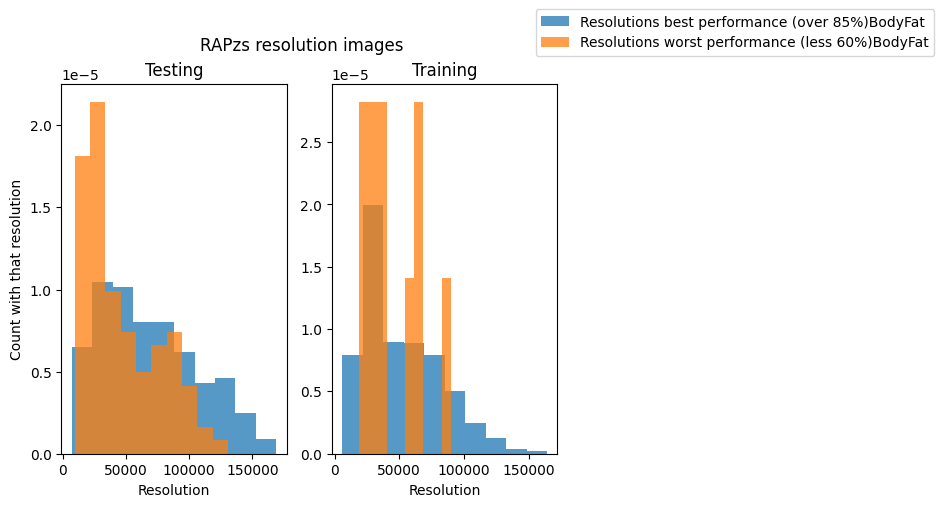

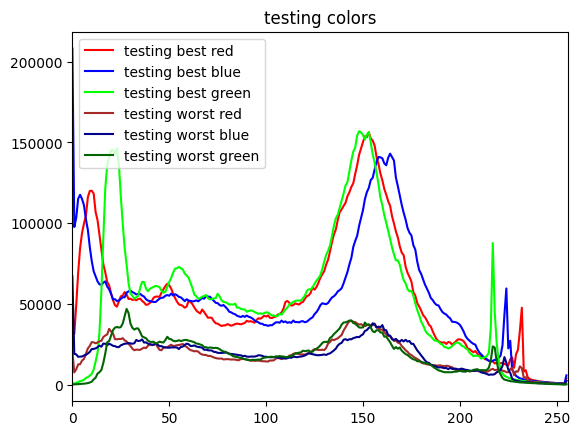

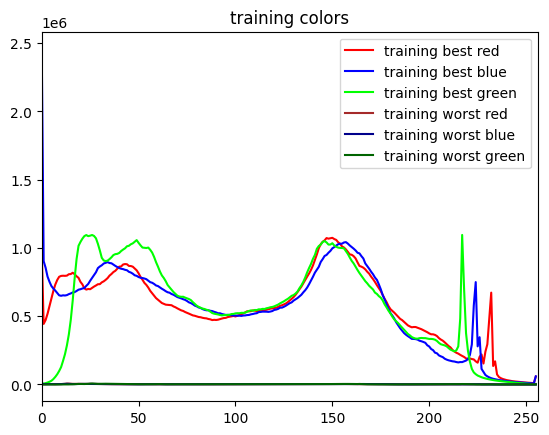

In [20]:
attributeToAnalyze='BodyFat'
listAttributes=listAttributesRAPzs
listNameTrainingBestColorR, listNameTrainingBestColorG, listNameTrainingBestColorB,listNameTrainingWorstColorR, listNameTrainingWorstColorG, listNameTrainingWorstColorB, listNameTestingWorstColorR, listNameTestingWorstColorG, listNameTestingWorstColorB, listNameTestingBestColorR, listNameTestingBestColorG, listNameTestingBestColorB, listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions = getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes)

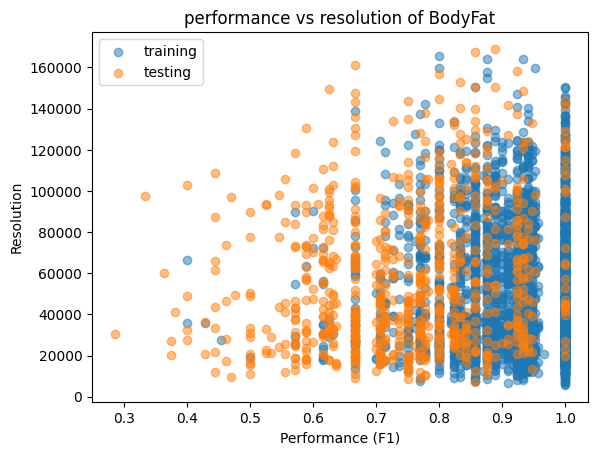

In [38]:
attributeToAnalyze='BodyFat'
listPerfTraining, listResolutionTraining = getPerfAndResolutionTraining(attributeToAnalyze, jsonTrainingGTPredicted, listAttributesRAPzs,jsonTrainingInstance)
listPerfTesting, listResolutionTesting = getPerfAndResolutionTesting(attributeToAnalyze, jsonTestingGTPredicted, listAttributesRAPzs,jsonTestingInstance)
plt.scatter(listPerfTraining, listResolutionTraining, alpha=0.5, label='training')
plt.scatter(listPerfTesting, listResolutionTesting, alpha=0.5,label='testing')
plt.legend()
plt.title('performance vs resolution of '+attributeToAnalyze)
plt.xlabel('Performance (F1)')
plt.ylabel('Resolution')
plt.show()

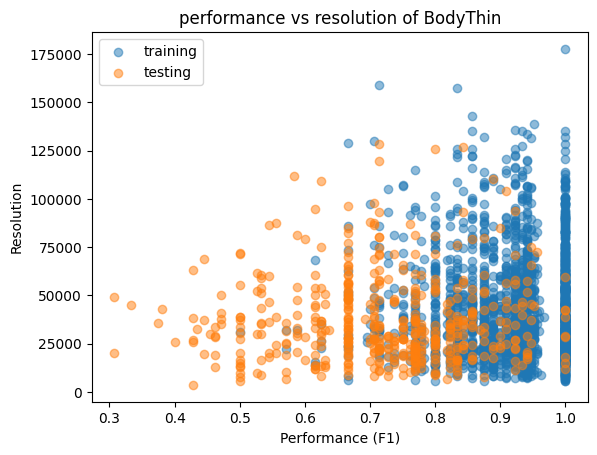

In [40]:
attributeToAnalyze='BodyThin'
listPerfTraining, listResolutionTraining = getPerfAndResolutionTraining(attributeToAnalyze, jsonTrainingGTPredicted, listAttributesRAPzs,jsonTrainingInstance)
listPerfTesting, listResolutionTesting = getPerfAndResolutionTesting(attributeToAnalyze, jsonTestingGTPredicted, listAttributesRAPzs,jsonTestingInstance)
plt.scatter(listPerfTraining, listResolutionTraining, alpha=0.5, label='training')
plt.scatter(listPerfTesting, listResolutionTesting, alpha=0.5,label='testing')
plt.legend()
plt.title('performance vs resolution of '+attributeToAnalyze)
plt.xlabel('Performance (F1)')
plt.ylabel('Resolution')
plt.show()

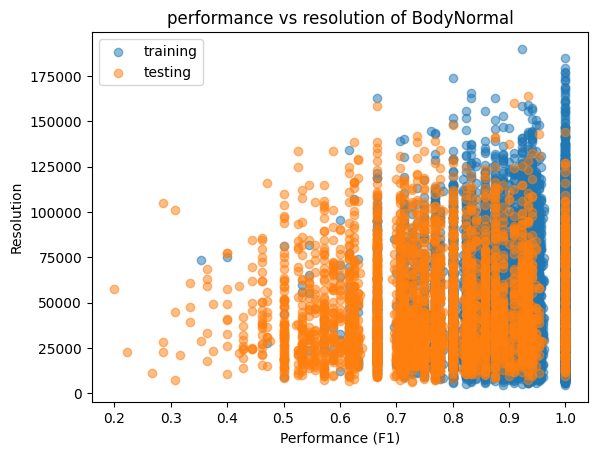

In [41]:
attributeToAnalyze='BodyNormal'
listPerfTraining, listResolutionTraining = getPerfAndResolutionTraining(attributeToAnalyze, jsonTrainingGTPredicted, listAttributesRAPzs,jsonTrainingInstance)
listPerfTesting, listResolutionTesting = getPerfAndResolutionTesting(attributeToAnalyze, jsonTestingGTPredicted, listAttributesRAPzs,jsonTestingInstance)
plt.scatter(listPerfTraining, listResolutionTraining, alpha=0.5, label='training')
plt.scatter(listPerfTesting, listResolutionTesting, alpha=0.5,label='testing')
plt.legend()
plt.title('performance vs resolution of '+attributeToAnalyze)
plt.xlabel('Performance (F1)')
plt.ylabel('Resolution')
plt.show()

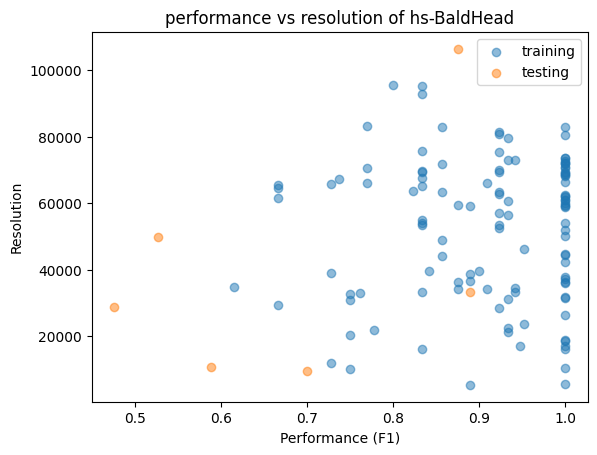

In [39]:
attributeToAnalyze='hs-BaldHead'
listPerfTraining, listResolutionTraining = getPerfAndResolutionTraining(attributeToAnalyze, jsonTrainingGTPredicted, listAttributesRAPzs,jsonTrainingInstance)
listPerfTesting, listResolutionTesting = getPerfAndResolutionTesting(attributeToAnalyze, jsonTestingGTPredicted, listAttributesRAPzs,jsonTestingInstance)

plt.scatter(listPerfTraining, listResolutionTraining, alpha=0.5, label='training')
plt.scatter(listPerfTesting, listResolutionTesting, alpha=0.5,label='testing')
plt.legend()
plt.title('performance vs resolution of '+attributeToAnalyze)
plt.xlabel('Performance (F1)')
plt.ylabel('Resolution')
plt.show()

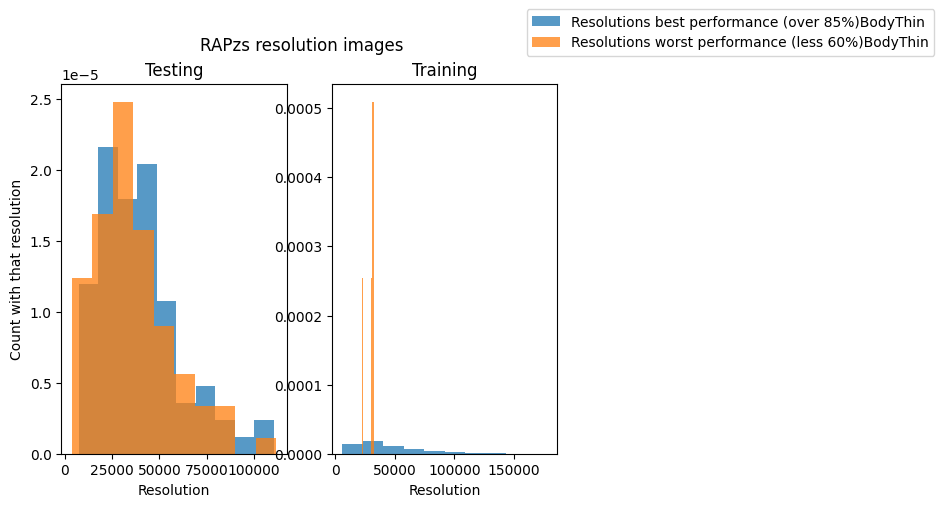

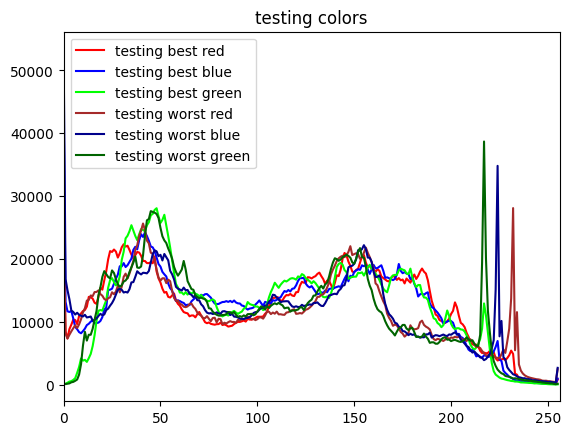

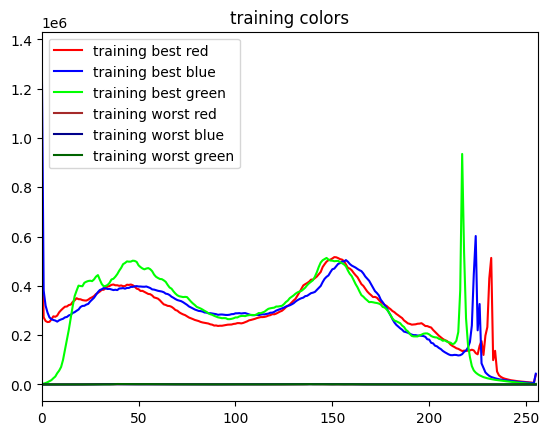

In [ ]:
attributeToAnalyze='BodyThin'
listAttributes=listAttributesRAPzs
listNameTrainingBestColorR, listNameTrainingBestColorG, listNameTrainingBestColorB,listNameTrainingWorstColorR, listNameTrainingWorstColorG, listNameTrainingWorstColorB, listNameTestingWorstColorR, listNameTestingWorstColorG, listNameTestingWorstColorB, listNameTestingBestColorR, listNameTestingBestColorG, listNameTestingBestColorB, listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions = getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes)

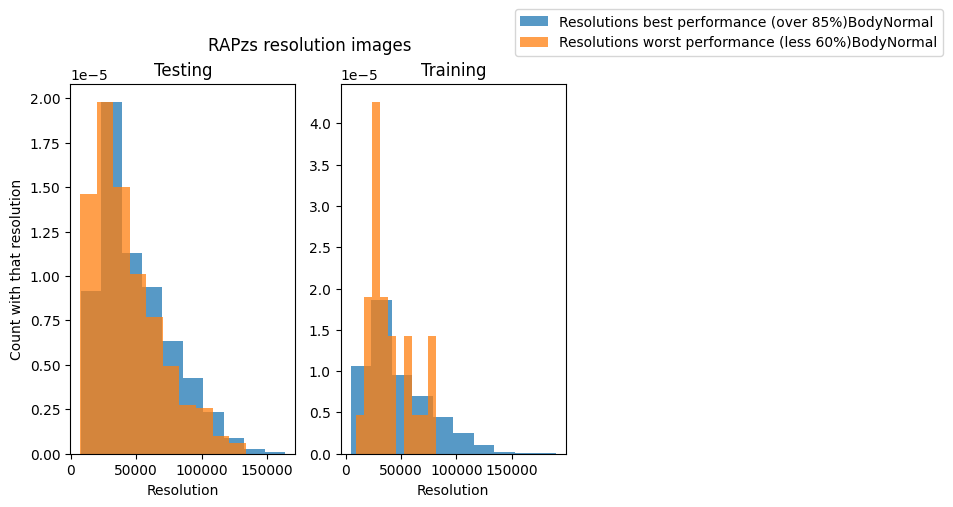

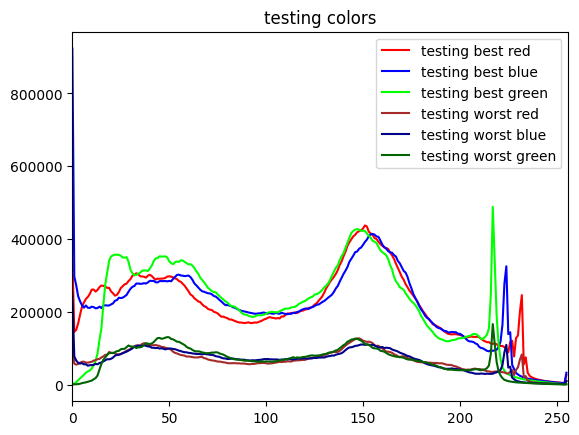

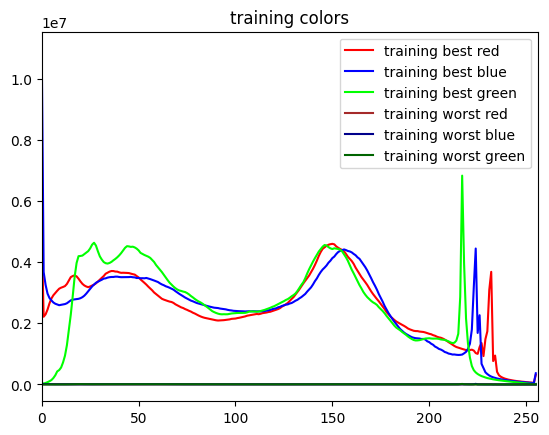

In [ ]:
attributeToAnalyze='BodyNormal'
listAttributes=listAttributesRAPzs
listNameTrainingBestColorR, listNameTrainingBestColorG, listNameTrainingBestColorB,listNameTrainingWorstColorR, listNameTrainingWorstColorG, listNameTrainingWorstColorB, listNameTestingWorstColorR, listNameTestingWorstColorG, listNameTestingWorstColorB, listNameTestingBestColorR, listNameTestingBestColorG, listNameTestingBestColorB, listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions = getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes)

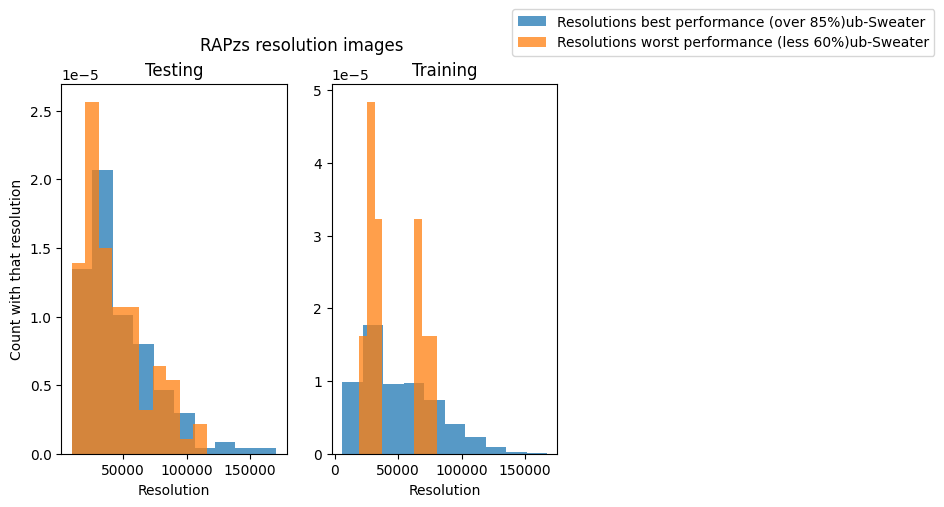

In [53]:
attributeToAnalyze='ub-Sweater'
listAttributes=listAttributesRAPzs
listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions = getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes)

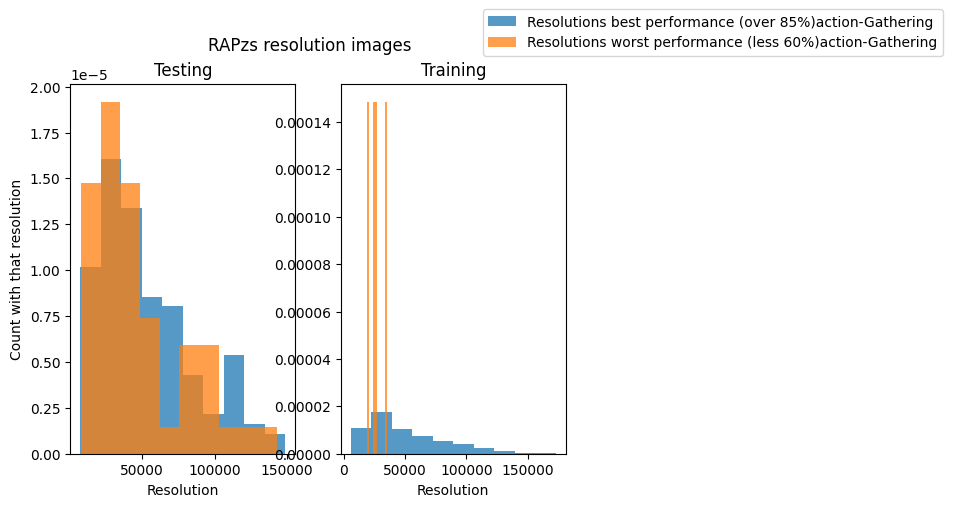

In [54]:
attributeToAnalyze='action-Gathering'
listAttributes=listAttributesRAPzs
listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions = getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes)

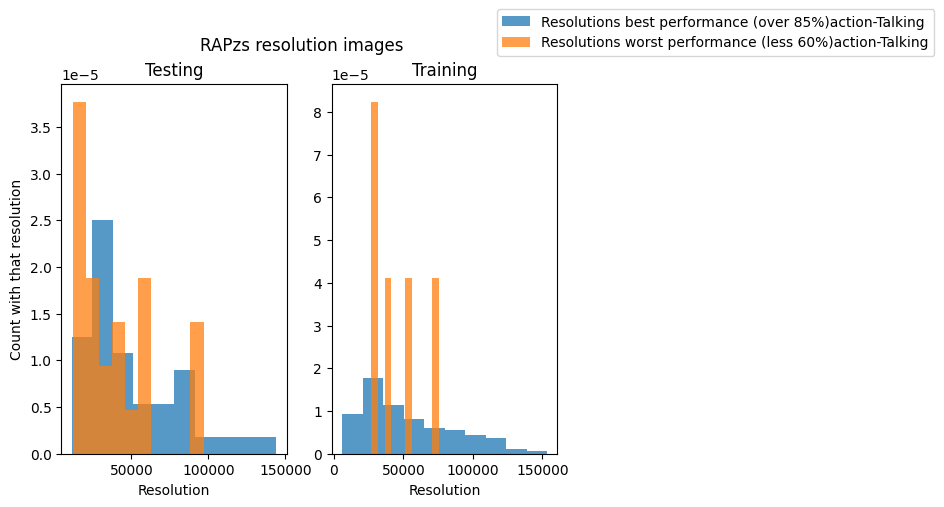

In [55]:
attributeToAnalyze='action-Talking'
listAttributes=listAttributesRAPzs
listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions = getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes)

In [ ]:
attributeToAnalyze='shoes-Casual'
listAttributes=listAttributesRAPzs
listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions = getDistributionResolutions(attributeToAnalyze, listAttributes, listIdentitiesNameTestingBestAllAttributes, listIdentitiesNameTestingWorstAllAttributes, listIdentitiesNameTrainingBestAllAttributes, listIdentitiesNameTrainingWorstAllAttributes)

In [34]:
def getCorrelationResolutions(attributeToAnalyze, listIdentitiesPerfTestingBestAllAttributes, listIdentitiesPerfTestingWorstAllAttributes, listIdentitiesPerfTrainingBestAllAttributes, listIdentitiesPerfTrainingWorstAllAttributes, listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions):
    # get index of the attribute
    indexAttribute = listAttributes.index(attributeToAnalyze)

    # get list name images of the index
    listPerfTestingBest = listIdentitiesPerfTestingBestAllAttributes[indexAttribute]
    listPerfTestingWorst = listIdentitiesPerfTestingWorstAllAttributes[indexAttribute]
    listPerfTrainingBest = listIdentitiesPerfTrainingBestAllAttributes[indexAttribute]
    listPerfTrainingWorst = listIdentitiesPerfTrainingWorstAllAttributes[indexAttribute]

    # correlate resolution and performance of each list
    nplistPerfTestingBest = np.array(listPerfTestingBest)
    nplistResoTestingBest = np.array(listNameTestingBestResolutions)

    print(np.corrcoef(nplistPerfTestingBest, nplistResoTestingBest))

    nplistPerfTestingWorst = np.array(listPerfTestingWorst)
    nplistResoTestingWorst = np.array(listNameTestingWorstResolutions)

    print(np.corrcoef(nplistPerfTestingWorst, nplistResoTestingWorst))

    nplistPerfTrainingBest = np.array(listPerfTrainingBest)
    nplistResoTrainingBest = np.array(listNameTrainingBestResolutions)

    print(np.corrcoef(nplistPerfTrainingBest, nplistResoTrainingBest))

    nplistPerfTrainingWorst = np.array(listPerfTrainingWorst)
    nplistResoTrainingWorst = np.array(listNameTrainingWorstResolutions)

    print(np.corrcoef(nplistPerfTrainingWorst, nplistResoTrainingWorst))

    return

In [35]:
getCorrelationResolutions(attributeToAnalyze, listIdentitiesPerfTestingBestAllAttributes, listIdentitiesPerfTestingWorstAllAttributes, listIdentitiesPerfTrainingBestAllAttributes, listIdentitiesPerfTrainingWorstAllAttributes, listNameTrainingBestResolutions, listNameTrainingWorstResolutions, listNameTestingBestResolutions, listNameTestingWorstResolutions)

[[1.         0.01048019]
 [0.01048019 1.        ]]
[[1.         0.01613259]
 [0.01613259 1.        ]]
[[ 1.         -0.00863183]
 [-0.00863183  1.        ]]
[[1.         0.20560086]
 [0.20560086 1.        ]]
